This notebook investigates to what extent "clouds" close the budget for certain relevant variables such as liquid water, mass flux etc. "Clouds" are decomposed with two different thresholds: initially simply by considering all points containing liquid water and then a threshold which includes both liquid water and vertical velocity (updraft). 

The idea is is similar to the work done by Siebesma & Cuijpers (1994) who discovered that "estimates of turbulent fluxes by bulk cloud updrafts and environmental downdrafts give an underestimation of 20% to 50% depending on the variable that is transported" 

Here, I use the data from the RICO simulation to calculate the total variable and then compare it to the result from the cloudtracking algorithm, initally for liquid water. 

Check mass flux first and then dive into the rest as specified by Siebesma & Cuijpers (1994).

# Mass flux
 Equations and calculations so far (Definition from Arakawa, only pertinent to the different between plume and environment)
 

Mass flux
$$
    \phi_m = \rho w A
$$

Density
$$
\rho = \frac{p_d}{R_d T} + \frac{p_v}{R_v T} + q_l \rho_l,
$$

Partial pressures
$$
p_v = \frac{q_v}{q_v + \epsilon} p
$$

Temperature
$$
    T \approx \theta_l\Big(\frac{c_{pd}}{c_{pd} - L_v q_l}\Big)\Big(\frac{p_0}{p}\Big)^{-\kappa}
$$

In [45]:
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapour
L_v = 2268000.0  # J/kg latent heat of vaporisation
p_0 = 100000.0  # Pa standard pressure at sea level
rho_l = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
horizontal_resolution = 25.0
liquid_water_threshold = 0.000001
vertical_velocity_threshold = 0.0


def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_temperature(theta_l, p, q_t, q_l, q_v):
    """Calculate temperature from theta_l, pressure, total water, and water vapor mixing ratios."""
    kappa = (R_d / c_pd) * ((1 + q_v / epsilon) / (1 + q_v * (c_pv / c_pd)))
    T = theta_l * (c_pd / (c_pd - L_v * q_l)) * (p_0 / p) ** (-kappa)
    return T

def calculate_density(T, p, q_l, q_v):
    """Calculate air density from temperature, pressure, and liquid water mixing ratio."""
    p_v = (q_v / (q_v + epsilon)) * p
    rho = (p - p_v) / (R_d * T) + (p_v / (R_v * T)) + (q_l * rho_l)
    return rho

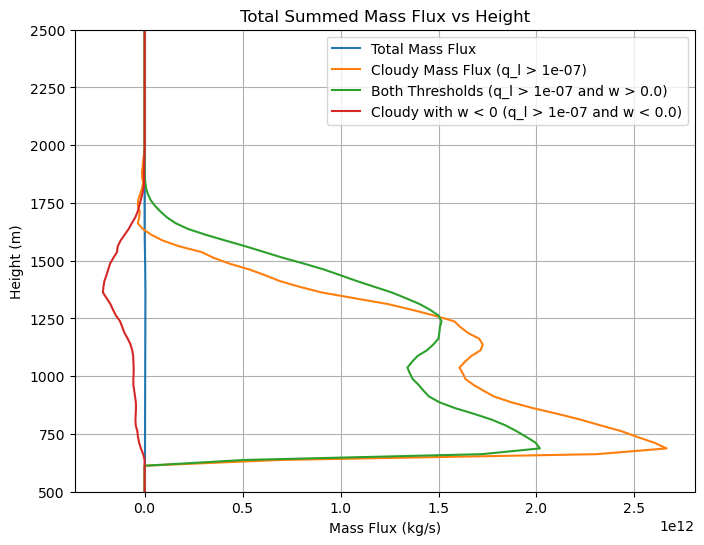

In [66]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Constants
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapour
L_v = 2268000.0  # J/kg latent heat of vaporisation
p_0 = 100000.0  # Pa standard pressure at sea level
rho_l = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
horizontal_resolution = 25.0  # in meters

# Thresholds
liquid_water_threshold = 0.0000001
vertical_velocity_threshold = 0.0

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_temperature(theta_l, p, q_t, q_l, q_v):
    """Calculate temperature from theta_l, pressure, total water, and water vapor mixing ratios."""
    kappa = (R_d / c_pd) * ((1 + q_v / epsilon) / (1 + q_v * (c_pv / c_pd)))
    T = theta_l * (c_pd / (c_pd - L_v * q_l)) * (p_0 / p) ** (-kappa)
    return T

def calculate_density(T, p, q_l, q_v):
    """Calculate air density from temperature, pressure, and liquid water mixing ratio."""
    p_v = (q_v / (q_v + epsilon)) * p
    rho = (p - p_v) / (R_d * T) + (p_v / (R_v * T)) + (q_l * rho_l)
    return rho

def calculate_mass_flux_and_density(timestep):
    zt_values = load_zt_values(l_file)
    with nc.Dataset(w_file) as ds:
        y_dim, x_dim = ds.dimensions['yt'].size, ds.dimensions['xt'].size

    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    p_data = load_data_all_levels(p_file, 'p', timestep)
    q_data = load_data_all_levels(q_file, 'q', timestep)
    t_data = load_data_all_levels(t_file, 't', timestep)
    
    T = calculate_temperature(t_data, p_data, q_data / 1000, l_data / 1000, (q_data - l_data) / 1000)
    rho = calculate_density(T, p_data, l_data / 1000, (q_data - l_data) / 1000)
    mass_flux = w_data * rho * horizontal_resolution ** 2
    
    return mass_flux, rho, zt_values, y_dim, x_dim

# Specify the timestep to analyze
specified_timestep = 20

# Calculate mass flux and density for the specified timestep
mass_flux, rho, zt_values, y_dim, x_dim = calculate_mass_flux_and_density(specified_timestep)
l_data = load_data_all_levels(l_file, 'l', specified_timestep)
w_data = load_data_all_levels(w_file, 'w', specified_timestep)

# Calculate the mass flux for the entire field, cloudy areas, both thresholds, and areas with w < 0
mass_flux_total = mass_flux
mass_flux_cloudy = np.where(l_data > liquid_water_threshold, mass_flux, 0)
mass_flux_both = np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), mass_flux, 0)
mass_flux_w_neg = np.where((l_data > liquid_water_threshold) & (w_data < vertical_velocity_threshold), mass_flux, 0)

# Calculate the areas
total_area = y_dim * x_dim 
cloudy_area = np.count_nonzero(l_data > liquid_water_threshold) 
both_area = np.count_nonzero((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold))
w_neg_area = np.count_nonzero((l_data > liquid_water_threshold) & (w_data < vertical_velocity_threshold))

# Scale the mass flux by the areas
scaled_mass_flux_total = np.sum(mass_flux_total, axis=(1, 2)) * total_area
scaled_mass_flux_cloudy = np.sum(mass_flux_cloudy, axis=(1, 2)) * cloudy_area
scaled_mass_flux_both = np.sum(mass_flux_both, axis=(1, 2)) * both_area
scaled_mass_flux_w_neg = np.sum(mass_flux_w_neg, axis=(1, 2)) * w_neg_area

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(scaled_mass_flux_total, zt_values, label='Total Mass Flux')
ax.plot(scaled_mass_flux_cloudy, zt_values, label=f'Cloudy Mass Flux (q_l > {liquid_water_threshold})')
ax.plot(scaled_mass_flux_both, zt_values, label=f'Both Thresholds (q_l > {liquid_water_threshold} and w > {vertical_velocity_threshold})')
ax.plot(scaled_mass_flux_w_neg, zt_values, label=f'Cloudy with w < 0 (q_l > {liquid_water_threshold} and w < {vertical_velocity_threshold})')

ax.set_xlabel('Mass Flux (kg/s)')
ax.set_ylabel('Height (m)')
ax.set_title('Total Summed Mass Flux vs Height')
ax.grid(True)
#ax.set_xscale('log')
ax.set_ylim([500, 2500])
ax.legend()
plt.show()


**Total mass flux summed over all active points**. Active refers to the point that are above the threshold. Total mass flux is very small compared to other two as it involves both positive and negative contributions!


To find about about the absolute amounts of flux, the next plot shows the absolute values of mass flux added together: so even negative flux (downward facing) is added. 

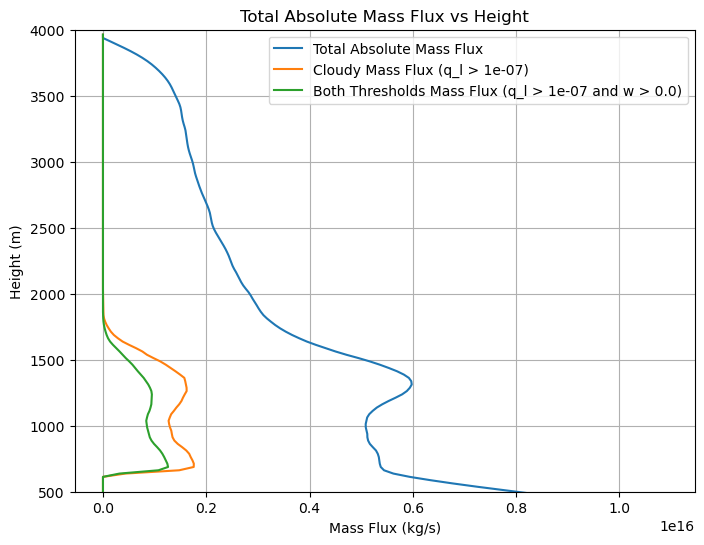

In [67]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

def calculate_mass_flux_and_density(timestep):
    zt_values = load_zt_values(l_file)
    with nc.Dataset(w_file) as ds:
        y_dim, x_dim = ds.dimensions['yt'].size, ds.dimensions['xt'].size

    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    p_data = load_data_all_levels(p_file, 'p', timestep)
    q_data = load_data_all_levels(q_file, 'q', timestep)
    t_data = load_data_all_levels(t_file, 't', timestep)
    
    T = calculate_temperature(t_data, p_data, q_data / 1000, l_data / 1000, (q_data - l_data) / 1000)
    rho = calculate_density(T, p_data, l_data / 1000, (q_data - l_data) / 1000)
    mass_flux = w_data * rho * horizontal_resolution ** 2
    
    return np.abs(mass_flux), rho, zt_values, y_dim, x_dim

# Specify the timestep to analyze
specified_timestep = 20  # Change this to the desired timestep

# Calculate mass flux and density for the specified timestep
mass_flux, rho, zt_values, y_dim, x_dim = calculate_mass_flux_and_density(specified_timestep)
l_data = load_data_all_levels(l_file, 'l', specified_timestep)
w_data = load_data_all_levels(w_file, 'w', specified_timestep)

# Calculate the mass flux for the entire field, cloudy areas, and both thresholds
mass_flux_total = mass_flux
mass_flux_cloudy = np.where(l_data > liquid_water_threshold, mass_flux, 0)
mass_flux_both = np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), mass_flux, 0)

# Calculate the areas
total_area = y_dim * x_dim * horizontal_resolution ** 2
cloudy_area = np.count_nonzero(l_data > liquid_water_threshold) * horizontal_resolution ** 2
both_area = np.count_nonzero((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold)) * horizontal_resolution ** 2

# Scale the mass flux by the areas
scaled_mass_flux_total = np.sum(mass_flux_total, axis=(1, 2)) * total_area
scaled_mass_flux_cloudy = np.sum(mass_flux_cloudy, axis=(1, 2)) * cloudy_area
scaled_mass_flux_both = np.sum(mass_flux_both, axis=(1, 2)) * both_area

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(scaled_mass_flux_total, zt_values, label='Total Absolute Mass Flux')
ax.plot(scaled_mass_flux_cloudy, zt_values, label=f'Cloudy Mass Flux (q_l > {liquid_water_threshold})')
ax.plot(scaled_mass_flux_both, zt_values, label=f'Both Thresholds Mass Flux (q_l > {liquid_water_threshold} and w > {vertical_velocity_threshold})')

ax.set_xlabel('Mass Flux (kg/s)')
ax.set_ylabel('Height (m)')
ax.set_title('Total Absolute Mass Flux vs Height')
ax.grid(True)
ax.set_ylim([500, 4000])
ax.legend()

plt.show()


## Average over first X minutes

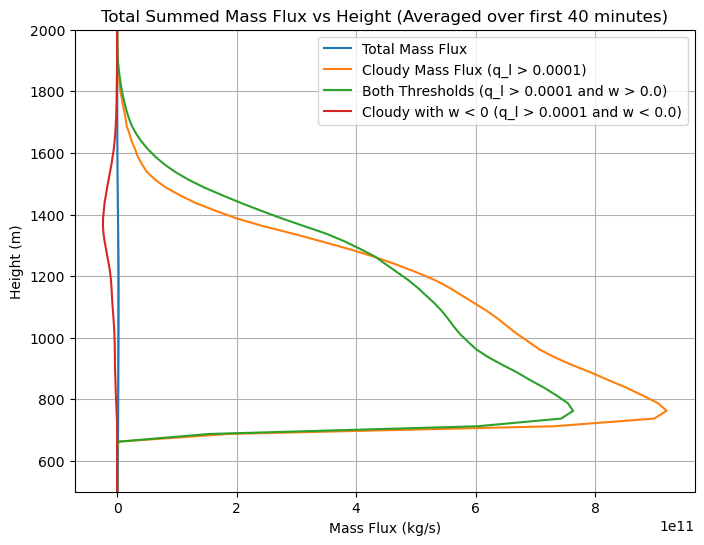

In [65]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'

# Averaging over the first specified number of minutes
def average_mass_flux_over_minutes(minutes):
    timesteps = minutes // 4  # Assuming each timestep is 4 minutes

    mass_flux_total = None
    mass_flux_cloudy = None
    mass_flux_both = None
    mass_flux_w_neg = None

    for timestep in range(timesteps):
        mass_flux, rho, zt_values, y_dim, x_dim = calculate_mass_flux_and_density(timestep)
        l_data = load_data_all_levels(l_file, 'l', timestep)
        w_data = load_data_all_levels(w_file, 'w', timestep)
        
        if mass_flux_total is None:
            mass_flux_total = mass_flux
            mass_flux_cloudy = np.where(l_data > liquid_water_threshold, mass_flux, 0)
            mass_flux_both = np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), mass_flux, 0)
            mass_flux_w_neg = np.where((l_data > liquid_water_threshold) & (w_data < vertical_velocity_threshold), mass_flux, 0)
        else:
            mass_flux_total += mass_flux
            mass_flux_cloudy += np.where(l_data > liquid_water_threshold, mass_flux, 0)
            mass_flux_both += np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), mass_flux, 0)
            mass_flux_w_neg += np.where((l_data > liquid_water_threshold) & (w_data < vertical_velocity_threshold), mass_flux, 0)

    mass_flux_total /= timesteps
    mass_flux_cloudy /= timesteps
    mass_flux_both /= timesteps
    mass_flux_w_neg /= timesteps

    total_area = y_dim * x_dim 
    cloudy_area = np.count_nonzero(l_data > liquid_water_threshold) 
    both_area = np.count_nonzero((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold))
    w_neg_area = np.count_nonzero((l_data > liquid_water_threshold) & (w_data < vertical_velocity_threshold))

    scaled_mass_flux_total = np.sum(mass_flux_total, axis=(1, 2)) * total_area
    scaled_mass_flux_cloudy = np.sum(mass_flux_cloudy, axis=(1, 2)) * cloudy_area
    scaled_mass_flux_both = np.sum(mass_flux_both, axis=(1, 2)) * both_area
    scaled_mass_flux_w_neg = np.sum(mass_flux_w_neg, axis=(1, 2)) * w_neg_area

    return scaled_mass_flux_total, scaled_mass_flux_cloudy, scaled_mass_flux_both, scaled_mass_flux_w_neg, zt_values

# Specify the number of minutes to average over
average_minutes = 40

scaled_mass_flux_total, scaled_mass_flux_cloudy, scaled_mass_flux_both, scaled_mass_flux_w_neg, zt_values = average_mass_flux_over_minutes(average_minutes)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(scaled_mass_flux_total, zt_values, label='Total Mass Flux')
ax.plot(scaled_mass_flux_cloudy, zt_values, label=f'Cloudy Mass Flux (q_l > {liquid_water_threshold})')
ax.plot(scaled_mass_flux_both, zt_values, label=f'Both Thresholds (q_l > {liquid_water_threshold} and w > {vertical_velocity_threshold})')
ax.plot(scaled_mass_flux_w_neg, zt_values, label=f'Cloudy with w < 0 (q_l > {liquid_water_threshold} and w < {vertical_velocity_threshold})')
ax.set_xlabel('Mass Flux (kg/s)')
ax.set_ylabel('Height (m)')
ax.set_title(f'Total Summed Mass Flux vs Height (Averaged over first {average_minutes} minutes)')
ax.grid(True)
ax.set_ylim([500, 2000])
ax.legend()
plt.show()


# Turbulent flux
## Disambiguation of the definitions

Decomposing the field into cloudy and environment areas to estimate how much of the total "flux" is captured by clouds.
1. Total field average (no cloud threshold)
2. Cloudy part threshold: liquid water
3. Cloudy part threshold: liquid water + updraft (positive vertical velocity). 

Deciding on how to best calculate $\big(\overline{w'\phi'}\big)$. Siebesma uses: 

$$\large \big(\overline{w'\phi'}\big) = a {\overline{w'\phi'}}^c  + (1-a) {\overline{w'\phi'}}^e + a(1-a)(w_c-w_e)(\phi_c-\phi_e)$$

where $a$ is the fraction of the active cloud park and $c$ and $e$ denote active cloud and passive environmental averages. The overbar denotes the average over the horizontal level of the model and prime denotes the deviation from the horizontal level average.

Siebesma continues that in mass flux parameterisation schemes, it is assumed that organised turbulence term is dominant, so that

$$\large \big(\overline{w'\phi'}\big) = a(1-a)(w_c-w_e)(\phi_c-\phi_e = \frac{M}{\rho}(\phi_c - \phi_e)$$

where $M$ is defined as a convective mass transport and $\rho$ is density. 





## Turbulent flux: Fractional coverage definition

Using this definition to start: 
$$\large \big(\overline{w'\phi'}\big) = a(1-a)(w_c-w_e)(\phi_c-\phi_e)$$

/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


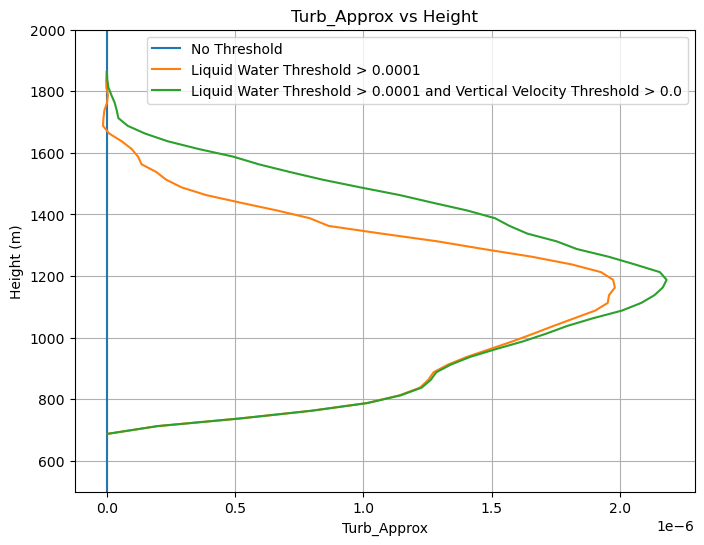

In [5]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

# Thresholds
liquid_water_threshold = 0.0001
vertical_velocity_threshold = 0.0

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

# Load zt values from the liquid water file
zt_values = load_zt_values(l_file)

# Averaging over the first 20 minutes
end_timestep = 5
w_sum_data = None
l_sum_data = None
cloudy_points = None
non_cloudy_points = None

for timestep in range(end_timestep):
    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    
    if w_sum_data is None:
        w_sum_data = w_data
        l_sum_data = l_data
        cloudy_points = np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), 1, 0)
        non_cloudy_points = np.where((l_data <= liquid_water_threshold) | (w_data <= vertical_velocity_threshold), 1, 0)
    else:
        w_sum_data += w_data
        l_sum_data += l_data
        cloudy_points += np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), 1, 0)
        non_cloudy_points += np.where((l_data <= liquid_water_threshold) | (w_data <= vertical_velocity_threshold), 1, 0)

average_w_data = w_sum_data / end_timestep
average_l_data = l_sum_data / end_timestep
fraction_cloudy = cloudy_points / end_timestep

turb_approx_no_threshold = []
turb_approx_liquid_threshold = []
turb_approx_both_thresholds = []

for z in range(average_w_data.shape[0]):
    w_mean = np.mean(average_w_data[z, :, :])
    q_mean = np.mean(average_l_data[z, :, :])
    
    mask_cloudy = (average_l_data[z, :, :] > liquid_water_threshold)
    mask_both = (average_l_data[z, :, :] > liquid_water_threshold) & (average_w_data[z, :, :] > vertical_velocity_threshold)
    
    w_c = np.mean(average_w_data[z, :, :][mask_cloudy])
    w_e = np.mean(average_w_data[z, :, :][~mask_cloudy])
    q_c = np.mean(average_l_data[z, :, :][mask_cloudy])
    q_e = np.mean(average_l_data[z, :, :][~mask_cloudy])
    a = np.mean(mask_cloudy)
    turb_approx_liquid_threshold.append(a * (1 - a) * (w_c - w_e) * (q_c - q_e))
    
    w_c_both = np.mean(average_w_data[z, :, :][mask_both])
    w_e_both = np.mean(average_w_data[z, :, :][~mask_both])
    q_c_both = np.mean(average_l_data[z, :, :][mask_both])
    q_e_both = np.mean(average_l_data[z, :, :][~mask_both])
    a_both = np.mean(mask_both)
    turb_approx_both_thresholds.append(a_both * (1 - a_both) * (w_c_both - w_e_both) * (q_c_both - q_e_both))
    
    turb_approx_no_threshold.append(w_mean * q_mean)  # Calculation for no threshold

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(turb_approx_no_threshold, zt_values, label='No Threshold')
ax.plot(turb_approx_liquid_threshold, zt_values, label=f'Liquid Water Threshold > {liquid_water_threshold}')
ax.plot(turb_approx_both_thresholds, zt_values, label=f'Liquid Water Threshold > {liquid_water_threshold} and Vertical Velocity Threshold > {vertical_velocity_threshold}')

ax.set_xlabel('Turb_Approx')
ax.set_ylabel('Height (m)')
ax.set_title('Turb_Approx vs Height')
ax.grid(True)
ax.set_ylim([500,2000])
ax.legend()


## Turbulent flux: mass flux definition
Using the definition that includes mass flux

$$\large \big(\overline{w'\phi'}\big) =  \frac{M}{\rho}(\phi_c - \phi_e)$$

requires the calculation of mass flux. 

### Questions/issues
- Is it calculated per unit area? YES! How do you define area when $(\phi_c - \phi_e)$?
- Is $M$ taken as the field mean? total field sum? is it in absolute terms? Since it's both positive and negative.
- How to calculate total $\big(\overline{w'\phi'}\big)$ with no thresholds?
- Why are the units the same no matter the variable (in the paper)?


### Step 1: calculating mass flux
From the output fields in the current RICO LES run which includes variables $q_l, \theta_l, p, w, $, mass flux can be reconstructed by first calculating the in-situ temperature, from which density can be calculated, which then finally gives mass flux.

In [6]:
import numpy as np
import netCDF4 as nc
import os

R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapour
L_v = 2268000.0  # J/kg latent heat of vaporisation
p_0 = 100000.0  # Pa standard pressure at sea level
rho_l = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
horizontal_resolution = 25.0

w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'


def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_temperature(theta_l, p, q_t, q_l, q_v):
    """Calculate temperature from theta_l, pressure, total water, and water vapor mixing ratios."""
    # Calculate kappa for each point
    kappa = (R_d / c_pd) * ((1 + q_v / epsilon) / (1 + q_v * (c_pv / c_pd)))
    # Calculate temperature
    T = theta_l * (c_pd / (c_pd - L_v * q_l)) * (p_0 / p) ** (-kappa)
    return T

def calculate_density(T, p, q_l, q_v):
    """Calculate air density from temperature, pressure, and liquid water mixing ratio."""
    # Partial pressure of vapor
    p_v = (q_v / (q_v + epsilon)) * p
    # Calculate density
    rho = (p - p_v) / (R_d * T) + (p_v / (R_v * T)) + (q_l * rho_l)
    return rho

# Function to calculate mass flux and density for a given timestep
def calculate_mass_flux_and_density(timestep):
    zt_values = load_zt_values(l_file)
    with nc.Dataset(w_file) as ds:
        y_dim, x_dim = ds.dimensions['yt'].size, ds.dimensions['xt'].size

    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    p_data = load_data_all_levels(p_file, 'p', timestep)
    q_data = load_data_all_levels(q_file, 'q', timestep)
    t_data = load_data_all_levels(t_file, 't', timestep)
    
    # Calculate temperature
    T = calculate_temperature(t_data, p_data, q_data/1000, l_data/1000, (q_data - l_data)/1000)
    
    # Calculate density
    rho = calculate_density(T, p_data, l_data/1000, (q_data - l_data)/1000)
    
    # Calculate mass flux
    mass_flux = w_data * rho * horizontal_resolution ** 2
    
    return mass_flux, rho, zt_values, y_dim, x_dim


In [7]:
# Choose a specific timestep
chosen_timestep = 7  # Set the desired timestep here

# Calculate mass flux and density for the chosen timestep
mass_flux, rho, zt_values, y_dim, x_dim = calculate_mass_flux_and_density(chosen_timestep)

# Save mass flux field to a new NetCDF file
mass_flux_output_file = f'/Users/jure/PhD/coding/RICO_1hr/rico.mass_flux_timestep_{chosen_timestep}.nc'
with nc.Dataset(mass_flux_output_file, 'w', format='NETCDF4') as ds_out:
    # Create dimensions
    ds_out.createDimension('time', 1)
    ds_out.createDimension('zt', len(zt_values))
    ds_out.createDimension('yt', y_dim)
    ds_out.createDimension('xt', x_dim)
    
    # Create variables
    time_var = ds_out.createVariable('time', 'f4', ('time',))
    zt_var = ds_out.createVariable('zt', 'f4', ('zt',))
    yt_var = ds_out.createVariable('yt', 'f4', ('yt',))
    xt_var = ds_out.createVariable('xt', 'f4', ('xt',))
    mass_flux_var = ds_out.createVariable('mass_flux', 'f4', ('time', 'zt', 'yt', 'xt',))
    
    # Write data to variables
    time_var[:] = [chosen_timestep]
    zt_var[:] = zt_values
    yt_var[:] = np.arange(y_dim)
    xt_var[:] = np.arange(x_dim)
    mass_flux_var[0, :, :, :] = mass_flux

print(f"Mass flux calculation for timestep {chosen_timestep} completed and saved to NetCDF.")

# Save density field to a new NetCDF file
density_output_file = f'/Users/jure/PhD/coding/RICO_1hr/rico.density_timestep_{chosen_timestep}.nc'
with nc.Dataset(density_output_file, 'w', format='NETCDF4') as ds_out:
    # Create dimensions
    ds_out.createDimension('time', 1)
    ds_out.createDimension('zt', len(zt_values))
    ds_out.createDimension('yt', y_dim)
    ds_out.createDimension('xt', x_dim)
    
    # Create variables
    time_var = ds_out.createVariable('time', 'f4', ('time',))
    zt_var = ds_out.createVariable('zt', 'f4', ('zt',))
    yt_var = ds_out.createVariable('yt', 'f4', ('yt',))
    xt_var = ds_out.createVariable('xt', 'f4', ('xt',))
    density_var = ds_out.createVariable('density', 'f4', ('time', 'zt', 'yt', 'xt',))
    
    # Write data to variables
    time_var[:] = [chosen_timestep]
    zt_var[:] = zt_values
    yt_var[:] = np.arange(y_dim)
    xt_var[:] = np.arange(x_dim)
    density_var[0, :, :, :] = rho

print(f"Density calculation for timestep {chosen_timestep} completed and saved to NetCDF.")

Mass flux calculation for timestep 7 completed and saved to NetCDF.
Density calculation for timestep 7 completed and saved to NetCDF.


/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/ma/core.py:5329: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


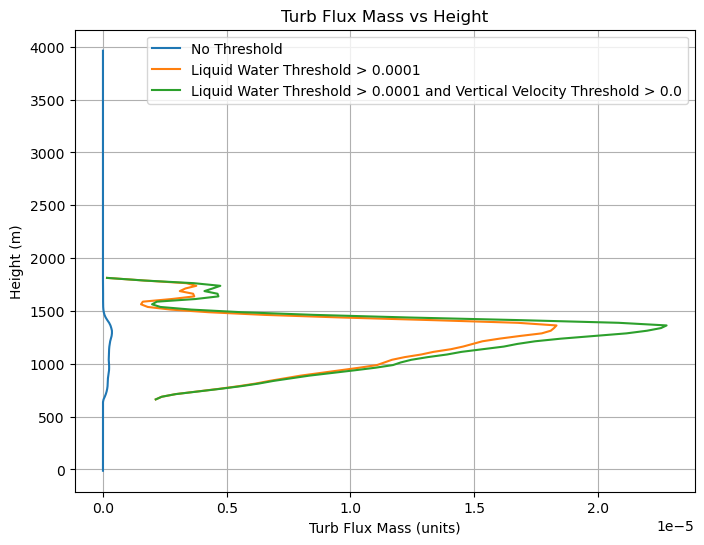

In [8]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Specify the chosen timestep
chosen_timestep = 6  # Set this to the desired timestep

# Paths to the NetCDF files
mass_flux_file = f'/Users/jure/PhD/coding/RICO_1hr/rico.mass_flux_timestep_{chosen_timestep}.nc'
density_file = f'/Users/jure/PhD/coding/RICO_1hr/rico.density_timestep_{chosen_timestep}.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'

# Thresholds
liquid_water_threshold = 0.0001
vertical_velocity_threshold = 0.0

def load_data_from_file(filename, var_name):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][:]
    return data

# Load data from NetCDF files
mass_flux = load_data_from_file(mass_flux_file, 'mass_flux')[0]  # Assuming time dimension is first
rho = load_data_from_file(density_file, 'density')[0]
zt_values = load_data_from_file(l_file, 'zt')
l_data = load_data_from_file(l_file, 'l')[chosen_timestep]
w_data = load_data_from_file(w_file, 'w')[chosen_timestep]

# Initialize arrays for turb_flux_mass
turb_flux_mass_no_threshold = np.zeros(len(zt_values))
turb_flux_mass_liquid_threshold = np.zeros(len(zt_values))
turb_flux_mass_both_thresholds = np.zeros(len(zt_values))

# Calculate turb_flux_mass for each height level
for z in range(len(zt_values)):
    mask_cloudy = (l_data[z, :, :] > liquid_water_threshold)
    mask_both = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] > vertical_velocity_threshold)
    
    q_l_c = np.mean(l_data[z, :, :][mask_cloudy])
    q_l_e = np.mean(l_data[z, :, :][~mask_cloudy])
    
    q_l_c_both = np.mean(l_data[z, :, :][mask_both])
    q_l_e_both = np.mean(l_data[z, :, :][~mask_both])
    
    M = np.mean(mass_flux[z, :, :])
    rho_mean = np.mean(rho[z, :, :])
    
    # For the no-threshold case, use the q_l values directly
    turb_flux_mass_no_threshold[z] = M / rho_mean * np.mean(l_data[z, :, :])
    turb_flux_mass_liquid_threshold[z] = M / rho_mean * (q_l_c - q_l_e)
    turb_flux_mass_both_thresholds[z] = M / rho_mean * (q_l_c_both - q_l_e_both)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(turb_flux_mass_no_threshold, zt_values, label='No Threshold')
ax.plot(turb_flux_mass_liquid_threshold, zt_values, label=f'Liquid Water Threshold > {liquid_water_threshold}')
ax.plot(turb_flux_mass_both_thresholds, zt_values, label=f'Liquid Water Threshold > {liquid_water_threshold} and Vertical Velocity Threshold > {vertical_velocity_threshold}')
ax.set_xlabel('Turb Flux Mass (units)')
ax.set_ylabel('Height (m)')
ax.set_title('Turb Flux Mass vs Height')
ax.grid(True)
ax.legend()


This probably shouldn't look like this. What have I dont to check if this is doing the right thing
1. Equations calculating mass flux, temperature density: they seem correct. 
2. The rho data also seems correctly calculated (Shape of the density dataset: (160, 512, 512)), gradually dropping from 1.2 at sea level to 0.8 at 4000m. 
3. Mass flux is negative: need to understand why! **Fixed**: water species ratios were not in the correct units (had to be divided by 1000). 

just multiply it with the actual value of the variable (in this case q_l (rather than (q_l_c - q_l_e)))

calculate the mss trqndport at ever single point. then you take the average over cloudy points and then you mutlpliy it with the number of cloudy points. ?

# VanZanten et al., 2011, RICO paper

They also plot the heat fluxes (in the standard units of $[\frac{W}{m^2}]$), but they define the surface sensible heat flux as 
$$\rho_0c_p\overline{w'\theta'}$$
and latent heat flux as 
$$\rho_0 L_v\overline{w'q_t'}$$
Comparing this to the equation (4.2) from (Siebesma & Cujipers, 1995): 
$$\big(w'\phi'\big) = \frac{M}{\rho}(\phi_c - \phi_e)$$
We can notice that when using this equation for $\theta_l$ for example, multiplying it with $\rho c_p$ produces a result in the units used in the S&C,1995 plot (heat flux units). Similarly, when using $q_t$, multiplying with $\rho L_v$ produces the correct units.




# - - - - - - - - - - - - - - - - - - - -RESOLVED- - - - - - - - - - - - - - - - - - - -
# On the Mass-Flux Representation of Vertical Transport in Moist, Zhu (2015)

Provides all the needed information

## for a single step

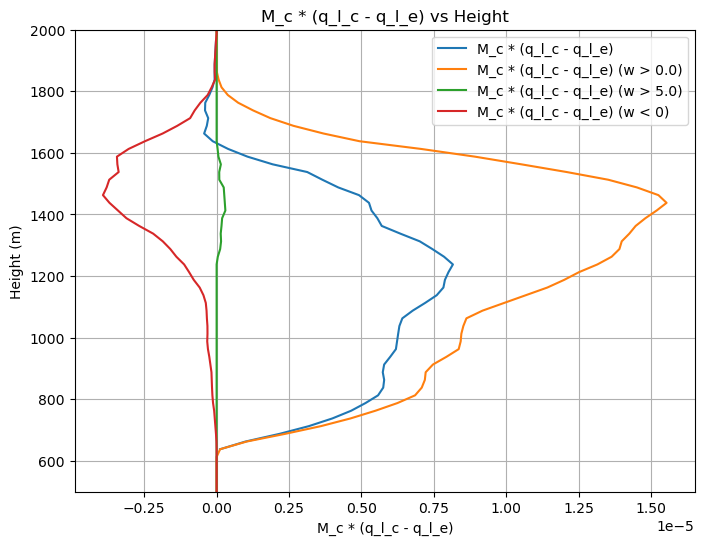

In [7]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Thresholds
liquid_water_threshold = 0.0000001
vertical_velocity_thresholds = [0.0, 5.0]

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

# Specify the timestep to analyze
specified_timestep = 20

# Load data for the specified timestep
w_data = load_data_all_levels(w_file, 'w', specified_timestep)
l_data = load_data_all_levels(l_file, 'l', specified_timestep)
zt_values = load_zt_values(l_file)

# Initialize the result arrays
M_c_values = []
M_c_values_w_thresholds = {threshold: [] for threshold in vertical_velocity_thresholds}
M_c_values_w_neg_threshold = []

for z in range(w_data.shape[0]):
    # Cloudy and environment masks
    cloudy_mask = l_data[z, :, :] > liquid_water_threshold
    environment_mask = ~cloudy_mask
    
    # Area fractions
    a = np.mean(cloudy_mask)
    
    # Mean vertical velocities
    w_c = np.mean(w_data[z, :, :][cloudy_mask])
    w_e = np.mean(w_data[z, :, :][environment_mask])
    
    # Mean liquid water contents
    q_l_c = np.mean(l_data[z, :, :][cloudy_mask])
    q_l_e = np.mean(l_data[z, :, :][environment_mask])
    
    # Calculate M_c
    M_c = a * (1 - a) * (w_c - w_e)
    
    # Multiply M_c with (q_l_c - q_l_e)
    result = M_c * (q_l_c - q_l_e)
    
    # Append the result for the current vertical level
    M_c_values.append(result)
    
    # Calculate for each vertical velocity threshold
    for threshold in vertical_velocity_thresholds:
        mask = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] > threshold)
        if np.any(mask):
            a_thresh = np.mean(mask)
            w_c_thresh = np.mean(w_data[z, :, :][mask])
            w_e_thresh = np.mean(w_data[z, :, :][~mask])
            q_l_c_thresh = np.mean(l_data[z, :, :][mask])
            q_l_e_thresh = np.mean(l_data[z, :, :][~mask])
            M_c_thresh = a_thresh * (1 - a_thresh) * (w_c_thresh - w_e_thresh)
            result_thresh = M_c_thresh * (q_l_c_thresh - q_l_e_thresh)
        else:
            result_thresh = 0
        M_c_values_w_thresholds[threshold].append(result_thresh)

    # Calculate for w < 0 threshold
    mask_neg = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] < 0)
    if np.any(mask_neg):
        a_neg = np.mean(mask_neg)
        w_c_neg = np.mean(w_data[z, :, :][mask_neg])
        w_e_neg = np.mean(w_data[z, :, :][~mask_neg])
        q_l_c_neg = np.mean(l_data[z, :, :][mask_neg])
        q_l_e_neg = np.mean(l_data[z, :, :][~mask_neg])
        M_c_neg = a_neg * (1 - a_neg) * (w_c_neg - w_e_neg)
        result_neg = M_c_neg * (q_l_c_neg - q_l_e_neg)
    else:
        result_neg = 0
    M_c_values_w_neg_threshold.append(result_neg)

# Convert the result lists to numpy arrays
M_c_values = np.array(M_c_values)
for threshold in vertical_velocity_thresholds:
    M_c_values_w_thresholds[threshold] = np.array(M_c_values_w_thresholds[threshold])
M_c_values_w_neg_threshold = np.array(M_c_values_w_neg_threshold)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(M_c_values, zt_values, label='M_c * (q_l_c - q_l_e)')
for threshold in vertical_velocity_thresholds:
    ax.plot(M_c_values_w_thresholds[threshold], zt_values, label=f'M_c * (q_l_c - q_l_e) (w > {threshold})')
ax.plot(M_c_values_w_neg_threshold, zt_values, label=f'M_c * (q_l_c - q_l_e) (w < 0)')

ax.set_xlabel('M_c * (q_l_c - q_l_e)')
ax.set_ylabel('Height (m)')
ax.set_title('M_c * (q_l_c - q_l_e) vs Height')
ax.grid(True)
ax.set_ylim([500, 2000])
ax.legend()
plt.show()


## Add fractional coverage of $a$ plot

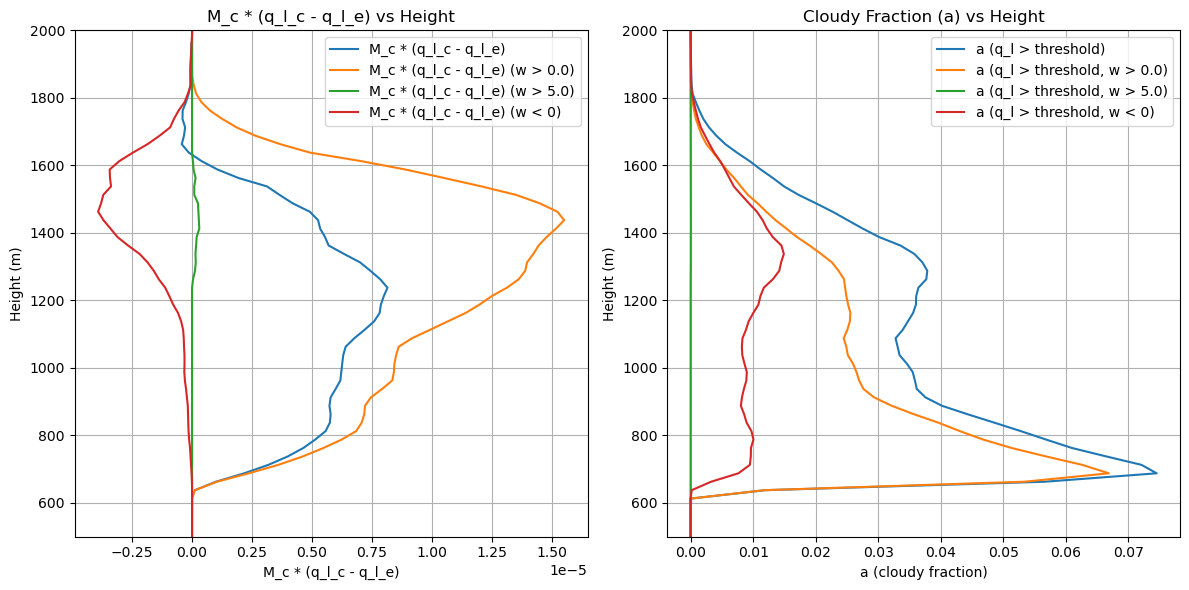

In [14]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Thresholds
liquid_water_threshold = 0.0000001
vertical_velocity_thresholds = [0.0, 5.0]

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

# Specify the timestep to analyze
specified_timestep = 20

# Load data for the specified timestep
w_data = load_data_all_levels(w_file, 'w', specified_timestep)
l_data = load_data_all_levels(l_file, 'l', specified_timestep)
zt_values = load_zt_values(l_file)

# Initialize the result arrays
M_c_values = []
M_c_values_w_thresholds = {threshold: [] for threshold in vertical_velocity_thresholds}
M_c_values_w_neg_threshold = []
a_values = []
a_values_w_thresholds = {threshold: [] for threshold in vertical_velocity_thresholds}
a_values_w_neg_threshold = []

for z in range(w_data.shape[0]):
    # Cloudy and environment masks
    cloudy_mask = l_data[z, :, :] > liquid_water_threshold
    environment_mask = ~cloudy_mask
    
    # Area fractions
    a = np.mean(cloudy_mask)
    a_values.append(a)
    
    # Mean vertical velocities
    w_c = np.mean(w_data[z, :, :][cloudy_mask])
    w_e = np.mean(w_data[z, :, :][environment_mask])
    
    # Mean liquid water contents
    q_l_c = np.mean(l_data[z, :, :][cloudy_mask])
    q_l_e = np.mean(l_data[z, :, :][environment_mask])
    
    # Calculate M_c
    M_c = a * (1 - a) * (w_c - w_e)
    
    # Multiply M_c with (q_l_c - q_l_e)
    result = M_c * (q_l_c - q_l_e)
    
    # Append the result for the current vertical level
    M_c_values.append(result)
    
    # Calculate for each vertical velocity threshold
    for threshold in vertical_velocity_thresholds:
        mask = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] > threshold)
        if np.any(mask):
            a_thresh = np.mean(mask)
            w_c_thresh = np.mean(w_data[z, :, :][mask])
            w_e_thresh = np.mean(w_data[z, :, :][~mask])
            q_l_c_thresh = np.mean(l_data[z, :, :][mask])
            q_l_e_thresh = np.mean(l_data[z, :, :][~mask])
            M_c_thresh = a_thresh * (1 - a_thresh) * (w_c_thresh - w_e_thresh)
            result_thresh = M_c_thresh * (q_l_c_thresh - q_l_e_thresh)
        else:
            a_thresh = 0
            result_thresh = 0
        M_c_values_w_thresholds[threshold].append(result_thresh)
        a_values_w_thresholds[threshold].append(a_thresh)

    # Calculate for w < 0 threshold
    mask_neg = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] < 0)
    if np.any(mask_neg):
        a_neg = np.mean(mask_neg)
        w_c_neg = np.mean(w_data[z, :, :][mask_neg])
        w_e_neg = np.mean(w_data[z, :, :][~mask_neg])
        q_l_c_neg = np.mean(l_data[z, :, :][mask_neg])
        q_l_e_neg = np.mean(l_data[z, :, :][~mask_neg])
        M_c_neg = a_neg * (1 - a_neg) * (w_c_neg - w_e_neg)
        result_neg = M_c_neg * (q_l_c_neg - q_l_e_neg)
    else:
        a_neg = 0
        result_neg = 0
    M_c_values_w_neg_threshold.append(result_neg)
    a_values_w_neg_threshold.append(a_neg)

# Convert the result lists to numpy arrays
M_c_values = np.array(M_c_values)
for threshold in vertical_velocity_thresholds:
    M_c_values_w_thresholds[threshold] = np.array(M_c_values_w_thresholds[threshold])
    a_values_w_thresholds[threshold] = np.array(a_values_w_thresholds[threshold])
M_c_values_w_neg_threshold = np.array(M_c_values_w_neg_threshold)
a_values = np.array(a_values)
a_values_w_neg_threshold = np.array(a_values_w_neg_threshold)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot M_c * (q_l_c - q_l_e)
ax1.plot(M_c_values, zt_values, label='M_c * (q_l_c - q_l_e)')
for threshold in vertical_velocity_thresholds:
    ax1.plot(M_c_values_w_thresholds[threshold], zt_values, label=f'M_c * (q_l_c - q_l_e) (w > {threshold})')
ax1.plot(M_c_values_w_neg_threshold, zt_values, label=f'M_c * (q_l_c - q_l_e) (w < 0)')

ax1.set_xlabel('M_c * (q_l_c - q_l_e)')
ax1.set_ylabel('Height (m)')
ax1.set_title('M_c * (q_l_c - q_l_e) vs Height')
ax1.grid(True)
ax1.set_ylim([500, 2000])
ax1.legend()

# Plot a values
ax2.plot(a_values, zt_values, label='a (q_l > threshold)')
for threshold in vertical_velocity_thresholds:
    ax2.plot(a_values_w_thresholds[threshold], zt_values, label=f'a (q_l > threshold, w > {threshold})')
ax2.plot(a_values_w_neg_threshold, zt_values, label=f'a (q_l > threshold, w < 0)')

ax2.set_xlabel('a (cloudy fraction)')
ax2.set_ylabel('Height (m)')
ax2.set_title('Cloudy Fraction (a) vs Height')
ax2.grid(True)
ax2.set_ylim([500, 2000])
ax2.legend()

plt.tight_layout()
plt.show()


## Average over time

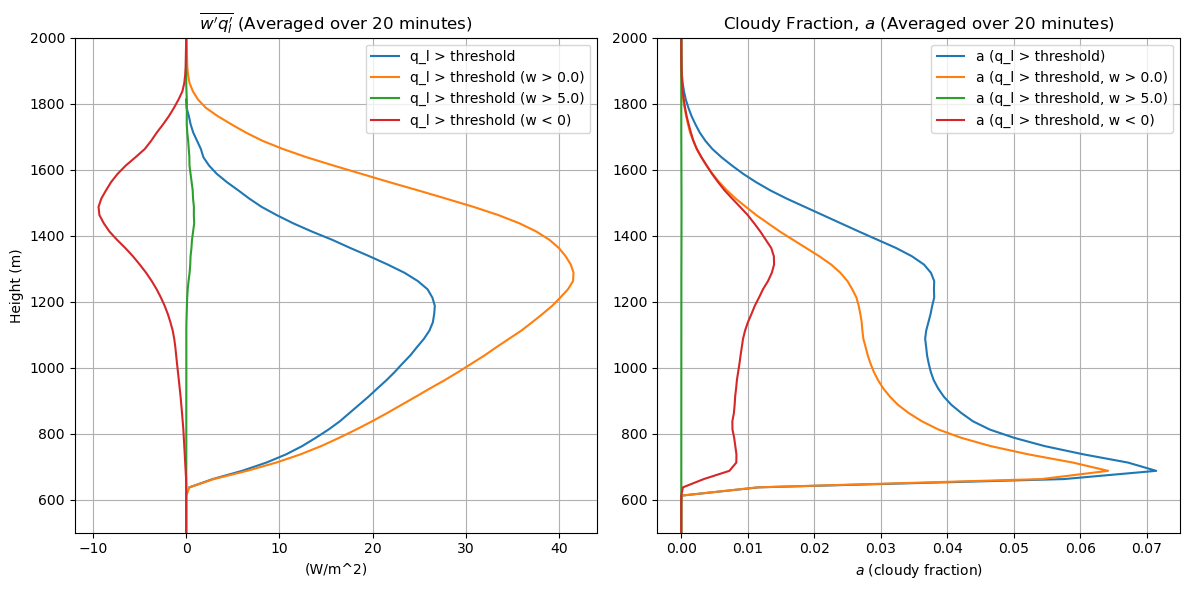

In [36]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Constants
liquid_water_threshold = 0.0000001
vertical_velocity_thresholds = [0.0, 5.0]
rho_0 = 1.25  # kg/m^3
L_v = 2268000.0  # J/kg

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_Mc_and_a(start_timestep, end_timestep):
    # Initialize the result arrays
    M_c_values = []
    M_c_values_w_thresholds = {threshold: [] for threshold in vertical_velocity_thresholds}
    M_c_values_w_neg_threshold = []
    a_values = []
    a_values_w_thresholds = {threshold: [] for threshold in vertical_velocity_thresholds}
    a_values_w_neg_threshold = []

    for timestep in range(start_timestep, end_timestep):
        w_data = load_data_all_levels(w_file, 'w', timestep)
        l_data = load_data_all_levels(l_file, 'l', timestep)
        
        for z in range(w_data.shape[0]):
            # Cloudy and environment masks
            cloudy_mask = l_data[z, :, :] > liquid_water_threshold
            environment_mask = ~cloudy_mask
            
            # Area fractions
            a = np.mean(cloudy_mask)
            a_values.append(a)
            
            # Mean vertical velocities
            w_c = np.mean(w_data[z, :, :][cloudy_mask])
            w_e = np.mean(w_data[z, :, :][environment_mask])
            
            # Mean liquid water contents
            q_l_c = np.mean(l_data[z, :, :][cloudy_mask])
            q_l_e = np.mean(l_data[z, :, :][environment_mask])
            
            # Calculate M_c
            M_c = a * (1 - a) * (w_c - w_e)
            
            # Multiply M_c with (q_l_c - q_l_e)
            result = M_c * (q_l_c - q_l_e)
            
            # Append the result for the current vertical level
            M_c_values.append(result)
            
            # Calculate for each vertical velocity threshold
            for threshold in vertical_velocity_thresholds:
                mask = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] > threshold)
                if np.any(mask):
                    a_thresh = np.mean(mask)
                    w_c_thresh = np.mean(w_data[z, :, :][mask])
                    w_e_thresh = np.mean(w_data[z, :, :][~mask])
                    q_l_c_thresh = np.mean(l_data[z, :, :][mask])
                    q_l_e_thresh = np.mean(l_data[z, :, :][~mask])
                    M_c_thresh = a_thresh * (1 - a_thresh) * (w_c_thresh - w_e_thresh)
                    result_thresh = M_c_thresh * (q_l_c_thresh - q_l_e_thresh)
                else:
                    a_thresh = 0
                    result_thresh = 0
                M_c_values_w_thresholds[threshold].append(result_thresh)
                a_values_w_thresholds[threshold].append(a_thresh)

            # Calculate for w < 0 threshold
            mask_neg = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] < 0)
            if np.any(mask_neg):
                a_neg = np.mean(mask_neg)
                w_c_neg = np.mean(w_data[z, :, :][mask_neg])
                w_e_neg = np.mean(w_data[z, :, :][~mask_neg])
                q_l_c_neg = np.mean(l_data[z, :, :][mask_neg])
                q_l_e_neg = np.mean(l_data[z, :, :][~mask_neg])
                M_c_neg = a_neg * (1 - a_neg) * (w_c_neg - w_e_neg)
                result_neg = M_c_neg * (q_l_c_neg - q_l_e_neg)
            else:
                a_neg = 0
                result_neg = 0
            M_c_values_w_neg_threshold.append(result_neg)
            a_values_w_neg_threshold.append(a_neg)

    # Convert the result lists to numpy arrays and average over the timesteps
    M_c_values = np.mean(np.array(M_c_values).reshape(-1, w_data.shape[0]), axis=0) * rho_0 * L_v
    for threshold in vertical_velocity_thresholds:
        M_c_values_w_thresholds[threshold] = np.mean(np.array(M_c_values_w_thresholds[threshold]).reshape(-1, w_data.shape[0]), axis=0) * rho_0 * L_v
        a_values_w_thresholds[threshold] = np.mean(np.array(a_values_w_thresholds[threshold]).reshape(-1, w_data.shape[0]), axis=0)
    M_c_values_w_neg_threshold = np.mean(np.array(M_c_values_w_neg_threshold).reshape(-1, w_data.shape[0]), axis=0) * rho_0 * L_v
    a_values = np.mean(np.array(a_values).reshape(-1, w_data.shape[0]), axis=0)
    a_values_w_neg_threshold = np.mean(np.array(a_values_w_neg_threshold).reshape(-1, w_data.shape[0]), axis=0)

    return M_c_values, M_c_values_w_thresholds, M_c_values_w_neg_threshold, a_values, a_values_w_thresholds, a_values_w_neg_threshold

# Load height values
zt_values = load_zt_values(l_file)

# Calculate for the first 20 minutes (timesteps 0-20)
M_c_values, M_c_values_w_thresholds, M_c_values_w_neg_threshold, a_values, a_values_w_thresholds, a_values_w_neg_threshold = calculate_Mc_and_a(15, 35)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot M_c * (q_l_c - q_l_e) multiplied by rho_0 and L_v
ax1.plot(M_c_values, zt_values, label='q_l > threshold')
for threshold in vertical_velocity_thresholds:
    ax1.plot(M_c_values_w_thresholds[threshold], zt_values, label=f'q_l > threshold (w > {threshold})')
ax1.plot(M_c_values_w_neg_threshold, zt_values, label=f'q_l > threshold (w < 0)')

ax1.set_xlabel('(W/m^2)')
ax1.set_ylabel('Height (m)')
ax1.set_title('$\overline{w^\prime q^\prime_l}$ (Averaged over 20 minutes)')
ax1.grid(True)
ax1.set_ylim([500, 2000])
ax1.legend()

# Plot a values
ax2.plot(a_values, zt_values, label='a (q_l > threshold)')
for threshold in vertical_velocity_thresholds:
    ax2.plot(a_values_w_thresholds[threshold], zt_values, label=f'a (q_l > threshold, w > {threshold})')
ax2.plot(a_values_w_neg_threshold, zt_values, label=f'a (q_l > threshold, w < 0)')

ax2.set_xlabel('$a$ (cloudy fraction)')
ax2.set_title('Cloudy Fraction, $a$ (Averaged over 20 minutes)')
ax2.grid(True)
ax2.set_ylim([500, 2000])
ax2.legend()

plt.tight_layout()
plt.show()

Figured out how to calculate decomposition works from Zhu 2015 paper (detail given about the decomposition) and VanZanten et al 2011 paper (detail on multiplication with $\rho_0L_v$ or $\rho_0c_p$ depending on the quantity involved. 

Do not know how to calculate the total value heat flux - could make use of the other VanZanten equations (check overleaf). 

Any other insights? Continue into producing this for other variables. Grab the percentages of the budget closed by coherent structures and move to cloud tracking. 

## Extra variables

/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/ma/core.py:5329: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


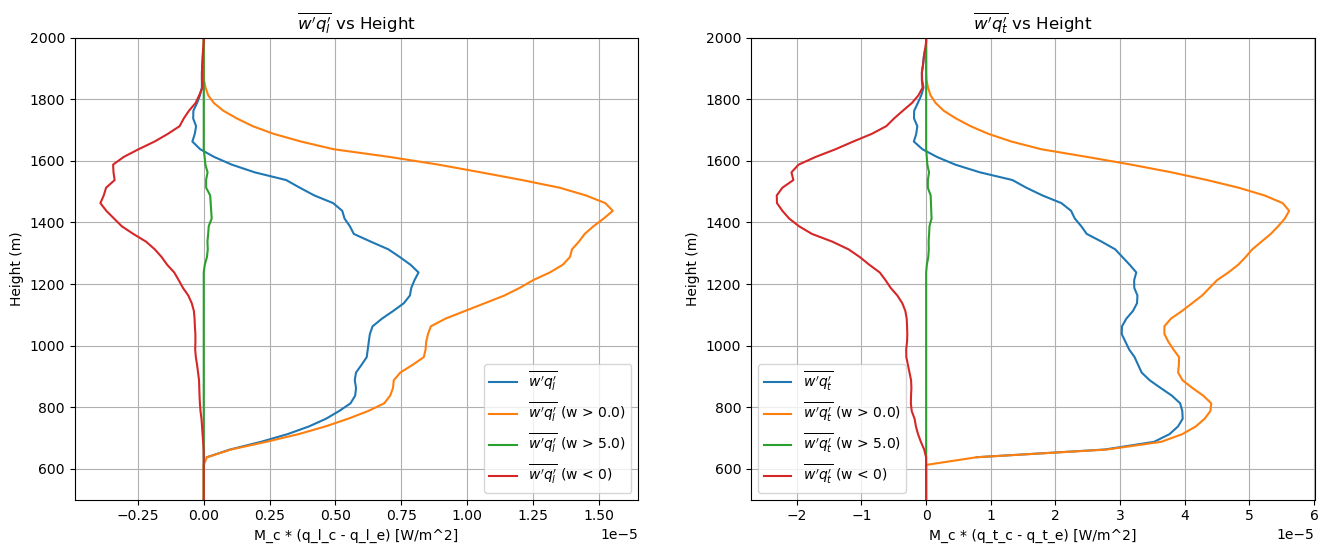

In [27]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Thresholds
liquid_water_threshold = 0.0000001
vertical_velocity_thresholds = [0.0, 5.0]

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_M_c_values(w_data, l_data, variable_data, liquid_water_threshold, vertical_velocity_thresholds):
    M_c_values = []
    M_c_values_w_thresholds = {threshold: [] for threshold in vertical_velocity_thresholds}
    M_c_values_w_neg_threshold = []

    for z in range(w_data.shape[0]):
        # Cloudy and environment masks
        cloudy_mask = l_data[z, :, :] > liquid_water_threshold
        environment_mask = ~cloudy_mask

        # Area fractions
        a = np.mean(cloudy_mask)

        # Mean vertical velocities
        w_c = np.mean(w_data[z, :, :][cloudy_mask])
        w_e = np.mean(w_data[z, :, :][environment_mask])

        # Mean variable contents
        var_c = np.mean(variable_data[z, :, :][cloudy_mask])
        var_e = np.mean(variable_data[z, :, :][environment_mask])

        # Calculate M_c
        M_c = a * (1 - a) * (w_c - w_e)

        # Multiply M_c with (var_c - var_e)
        result = M_c * (var_c - var_e)

        # Append the result for the current vertical level
        M_c_values.append(result)

        # Calculate for each vertical velocity threshold
        for threshold in vertical_velocity_thresholds:
            mask = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] > threshold)
            if np.any(mask):
                a_thresh = np.mean(mask)
                w_c_thresh = np.mean(w_data[z, :, :][mask])
                w_e_thresh = np.mean(w_data[z, :, :][~mask])
                var_c_thresh = np.mean(variable_data[z, :, :][mask])
                var_e_thresh = np.mean(variable_data[z, :, :][~mask])
                M_c_thresh = a_thresh * (1 - a_thresh) * (w_c_thresh - w_e_thresh)
                result_thresh = M_c_thresh * (var_c_thresh - var_e_thresh)
            else:
                result_thresh = 0
            M_c_values_w_thresholds[threshold].append(result_thresh)

        # Calculate for w < 0 threshold
        mask_neg = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] < 0)
        if np.any(mask_neg):
            a_neg = np.mean(mask_neg)
            w_c_neg = np.mean(w_data[z, :, :][mask_neg])
            w_e_neg = np.mean(w_data[z, :, :][~mask_neg])
            var_c_neg = np.mean(variable_data[z, :, :][mask_neg])
            var_e_neg = np.mean(variable_data[z, :, :][~mask_neg])
            M_c_neg = a_neg * (1 - a_neg) * (w_c_neg - w_e_neg)
            result_neg = M_c_neg * (var_c_neg - var_e_neg)
        else:
            result_neg = 0
        M_c_values_w_neg_threshold.append(result_neg)

    # Convert the result lists to numpy arrays
    M_c_values = np.array(M_c_values)
    for threshold in vertical_velocity_thresholds:
        M_c_values_w_thresholds[threshold] = np.array(M_c_values_w_thresholds[threshold])
    M_c_values_w_neg_threshold = np.array(M_c_values_w_neg_threshold)

    return M_c_values, M_c_values_w_thresholds, M_c_values_w_neg_threshold

# Specify the timestep to analyze
specified_timestep = 20

# Load data for the specified timestep
w_data = load_data_all_levels(w_file, 'w', specified_timestep)
l_data = load_data_all_levels(l_file, 'l', specified_timestep)
q_l_data = load_data_all_levels(q_file, 'q', specified_timestep)
zt_values = load_zt_values(l_file)

# Calculate M_c values for liquid water content
M_c_l_values, M_c_l_values_w_thresholds, M_c_l_values_w_neg_threshold = calculate_M_c_values(
    w_data, l_data, l_data, liquid_water_threshold, vertical_velocity_thresholds)

# Calculate M_c values for total water content
M_c_qt_values, M_c_qt_values_w_thresholds, M_c_qt_values_w_neg_threshold = calculate_M_c_values(
    w_data, l_data, q_l_data, liquid_water_threshold, vertical_velocity_thresholds)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for liquid water content
ax1.plot(M_c_l_values, zt_values, label=r'$\overline{w^{\prime}q_l^{\prime}}$')
for threshold in vertical_velocity_thresholds:
    ax1.plot(M_c_l_values_w_thresholds[threshold], zt_values, label=r'$\overline{w^{\prime}q_l^{\prime}}$' + f' (w > {threshold})')
ax1.plot(M_c_l_values_w_neg_threshold, zt_values, label=r'$\overline{w^{\prime}q_l^{\prime}}$' + ' (w < 0)')

ax1.set_xlabel('M_c * (q_l_c - q_l_e) [W/m^2]')
ax1.set_ylabel('Height (m)')
ax1.set_title(r'$\overline{w^{\prime}q_l^{\prime}}$ vs Height')
ax1.grid(True)
ax1.set_ylim([500, 2000])
ax1.legend()

# Plot for total water content
ax2.plot(M_c_qt_values, zt_values, label=r'$\overline{w^{\prime}q_t^{\prime}}$')
for threshold in vertical_velocity_thresholds:
    ax2.plot(M_c_qt_values_w_thresholds[threshold], zt_values, label=r'$\overline{w^{\prime}q_t^{\prime}}$' + f' (w > {threshold})')
ax2.plot(M_c_qt_values_w_neg_threshold, zt_values, label=r'$\overline{w^{\prime}q_t^{\prime}}$' + ' (w < 0)')

ax2.set_xlabel('M_c * (q_t_c - q_t_e) [W/m^2]')
ax2.set_ylabel('Height (m)')
ax2.set_title(r'$\overline{w^{\prime}q_t^{\prime}}$ vs Height')
ax2.grid(True)
ax2.set_ylim([500, 2000])
ax2.legend()

plt.show()


## Averaged over time

Changing to correct units, cleaning up plots. 

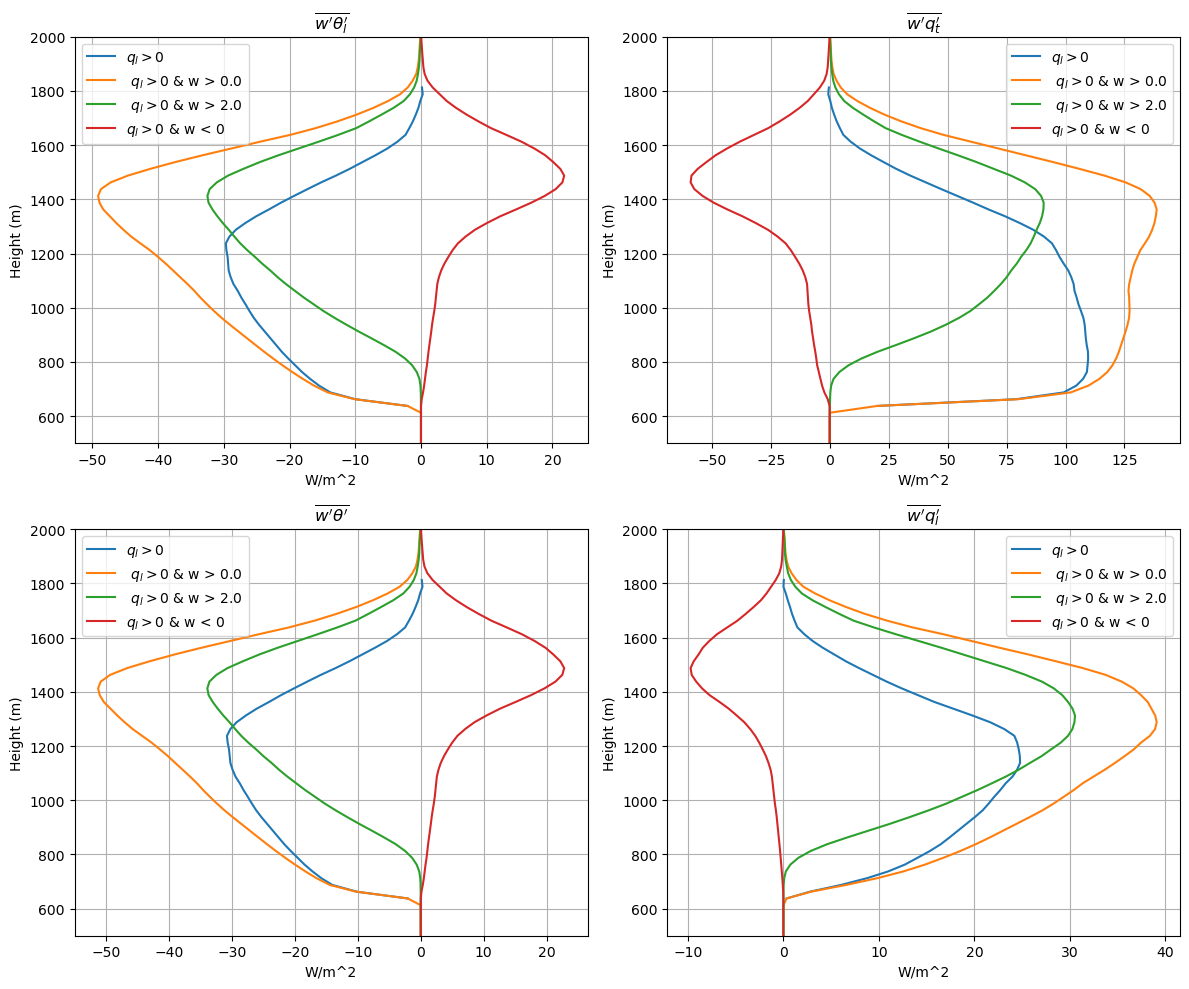

In [41]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Constants
rho_0 = 1.25  # kg/m^3
L_v = 2268000.0  # J/kg
c_p = 1004.0  # J/kg/K
R_d = 287.05  # J/kg/K gas constant for dry air
p_0 = 100000.0  # Pa standard pressure at sea level
kappa = R_d / c_p

# Thresholds
liquid_water_threshold = 0.0000001
vertical_velocity_thresholds = [0.0, 2.0]

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_theta(t_data, p_data):
    return t_data * (p_0 / p_data) ** kappa

def calculate_M_c_values(w_data, l_data, variable_data, liquid_water_threshold, vertical_velocity_thresholds, multiplier):
    M_c_values = []
    M_c_values_w_thresholds = {threshold: [] for threshold in vertical_velocity_thresholds}
    M_c_values_w_neg_threshold = []

    for z in range(w_data.shape[0]):
        # Cloudy and environment masks
        cloudy_mask = l_data[z, :, :] > liquid_water_threshold
        environment_mask = ~cloudy_mask

        # Area fractions
        a = np.mean(cloudy_mask)

        # Mean vertical velocities
        w_c = np.mean(w_data[z, :, :][cloudy_mask])
        w_e = np.mean(w_data[z, :, :][environment_mask])

        # Mean variable contents
        var_c = np.mean(variable_data[z, :, :][cloudy_mask])
        var_e = np.mean(variable_data[z, :, :][environment_mask])

        # Calculate M_c
        M_c = a * (1 - a) * (w_c - w_e)

        # Multiply M_c with (var_c - var_e) and the multiplier
        result = M_c * (var_c - var_e) * multiplier

        # Append the result for the current vertical level
        M_c_values.append(result)

        # Calculate for each vertical velocity threshold
        for threshold in vertical_velocity_thresholds:
            mask = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] > threshold)
            if np.any(mask):
                a_thresh = np.mean(mask)
                w_c_thresh = np.mean(w_data[z, :, :][mask])
                w_e_thresh = np.mean(w_data[z, :, :][~mask])
                var_c_thresh = np.mean(variable_data[z, :, :][mask])
                var_e_thresh = np.mean(variable_data[z, :, :][~mask])
                M_c_thresh = a_thresh * (1 - a_thresh) * (w_c_thresh - w_e_thresh)
                result_thresh = M_c_thresh * (var_c_thresh - var_e_thresh) * multiplier
            else:
                result_thresh = 0
            M_c_values_w_thresholds[threshold].append(result_thresh)

        # Calculate for w < 0 threshold
        mask_neg = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] < 0)
        if np.any(mask_neg):
            a_neg = np.mean(mask_neg)
            w_c_neg = np.mean(w_data[z, :, :][mask_neg])
            w_e_neg = np.mean(w_data[z, :, :][~mask_neg])
            var_c_neg = np.mean(variable_data[z, :, :][mask_neg])
            var_e_neg = np.mean(variable_data[z, :, :][~mask_neg])
            M_c_neg = a_neg * (1 - a_neg) * (w_c_neg - w_e_neg)
            result_neg = M_c_neg * (var_c_neg - var_e_neg) * multiplier
        else:
            result_neg = 0
        M_c_values_w_neg_threshold.append(result_neg)

    # Convert the result lists to numpy arrays
    M_c_values = np.array(M_c_values)
    for threshold in vertical_velocity_thresholds:
        M_c_values_w_thresholds[threshold] = np.array(M_c_values_w_thresholds[threshold])
    M_c_values_w_neg_threshold = np.array(M_c_values_w_neg_threshold)

    return M_c_values, M_c_values_w_thresholds, M_c_values_w_neg_threshold

def average_M_c_values_over_time(start_timestep, end_timestep, variable_data_loader, multiplier):
    M_c_values_total = None
    M_c_values_w_thresholds_total = {threshold: None for threshold in vertical_velocity_thresholds}
    M_c_values_w_neg_threshold_total = None

    for timestep in range(start_timestep, end_timestep):
        w_data = load_data_all_levels(w_file, 'w', timestep)
        l_data = load_data_all_levels(l_file, 'l', timestep)
        variable_data = variable_data_loader(timestep)

        M_c_values, M_c_values_w_thresholds, M_c_values_w_neg_threshold = calculate_M_c_values(
            w_data, l_data, variable_data, liquid_water_threshold, vertical_velocity_thresholds, multiplier
        )

        if M_c_values_total is None:
            M_c_values_total = M_c_values
            M_c_values_w_neg_threshold_total = M_c_values_w_neg_threshold
            for threshold in vertical_velocity_thresholds:
                M_c_values_w_thresholds_total[threshold] = M_c_values_w_thresholds[threshold]
        else:
            M_c_values_total += M_c_values
            M_c_values_w_neg_threshold_total += M_c_values_w_neg_threshold
            for threshold in vertical_velocity_thresholds:
                M_c_values_w_thresholds_total[threshold] += M_c_values_w_thresholds[threshold]

    num_timesteps = end_timestep - start_timestep
    M_c_values_total /= num_timesteps
    M_c_values_w_neg_threshold_total /= num_timesteps
    for threshold in vertical_velocity_thresholds:
        M_c_values_w_thresholds_total[threshold] /= num_timesteps

    return M_c_values_total, M_c_values_w_thresholds_total, M_c_values_w_neg_threshold_total

def plot_M_c_values(ax, M_c_values, M_c_values_w_thresholds, M_c_values_w_neg_threshold, title):
    ax.plot(M_c_values, zt_values, label='$q_l >0$')
    for threshold in vertical_velocity_thresholds:
        ax.plot(M_c_values_w_thresholds[threshold], zt_values, label=f' $q_l>0$ & w > {threshold}')
    ax.plot(M_c_values_w_neg_threshold, zt_values, label='$q_l > 0$ & w < 0')

    ax.set_xlabel('W/m^2')
    ax.set_ylabel('Height (m)')
    ax.set_title(title)
    ax.grid(True)
    ax.set_ylim([500, 2000])
    ax.legend()

# Specify the time range to analyze (e.g., timesteps 15 to 35)
start_timestep = 15
end_timestep = 25

# Load height values
zt_values = load_zt_values(l_file)

# Calculate and average M_c values for liquid water content
M_c_l_values, M_c_l_values_w_thresholds, M_c_l_values_w_neg_threshold = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(l_file, 'l', timestep), rho_0 * L_v)

# Calculate and average M_c values for total water content
M_c_qt_values, M_c_qt_values_w_thresholds, M_c_qt_values_w_neg_threshold = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(q_file, 'q', timestep), rho_0 * L_v)

# Calculate and average M_c values for liquid water potential temperature
M_c_theta_l_values, M_c_theta_l_values_w_thresholds, M_c_theta_l_values_w_neg_threshold = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(t_file, 't', timestep), rho_0 * c_p)

# Calculate and average M_c values for theta
M_c_theta_values, M_c_theta_values_w_thresholds, M_c_theta_values_w_neg_threshold = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: calculate_theta(load_data_all_levels(t_file, 't', timestep), load_data_all_levels(p_file, 'p', timestep)), rho_0 * c_p)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

plot_M_c_values(ax1, M_c_theta_l_values, M_c_theta_l_values_w_thresholds, M_c_theta_l_values_w_neg_threshold, r'$\overline{w^{\prime}\theta_l^{\prime}}$')
plot_M_c_values(ax2, M_c_qt_values, M_c_qt_values_w_thresholds, M_c_qt_values_w_neg_threshold, r'$\overline{w^{\prime}q_t^{\prime}}$')
plot_M_c_values(ax3, M_c_theta_values, M_c_theta_values_w_thresholds, M_c_theta_values_w_neg_threshold, r'$\overline{w^{\prime}\theta^{\prime}}$')
plot_M_c_values(ax4, M_c_l_values, M_c_l_values_w_thresholds, M_c_l_values_w_neg_threshold, r'$\overline{w^{\prime}q_l^{\prime}}$')

plt.tight_layout()
plt.show()


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_11906/3537862928.py:109: UserWarning: Warning: converting a masked element to nan.
  M_c_values = np.array(M_c_values)


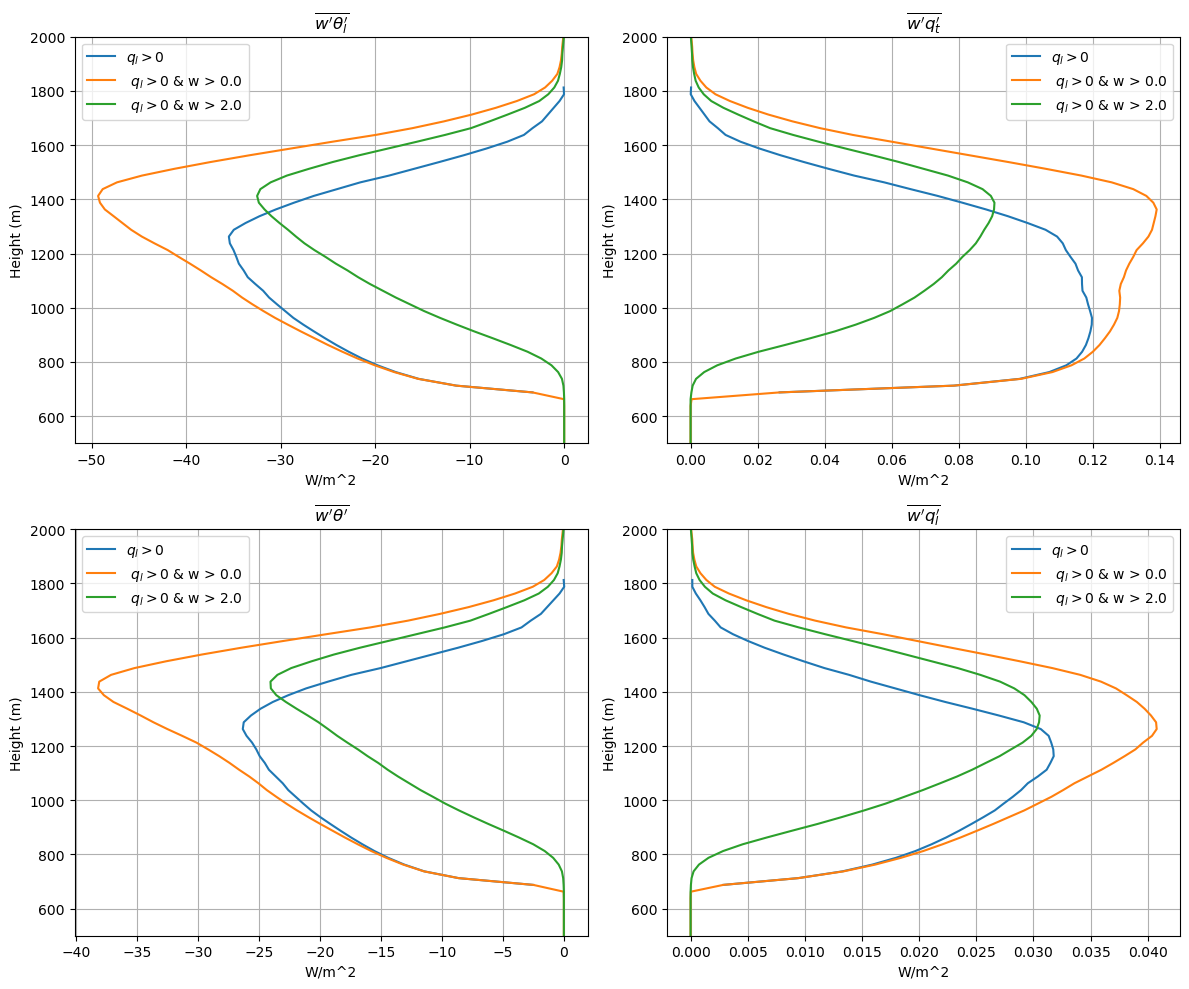

In [49]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Constants
rho_0 = 1.25  # kg/m^3
L_v = 2268000.0  # J/kg
c_p = 1004.0  # J/kg/K
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
p_0 = 100000.0  # Pa standard pressure at sea level
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapor
rho_l = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
kappa = R_d / c_p

# Thresholds
liquid_water_threshold = 0.0000001
vertical_velocity_thresholds = [0.0, 2.0]

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'

def load_data_all_levels(filename, var_name, timestep, scale_factor=1.0):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :] * scale_factor  # Extract all levels for the timestep and apply scale factor
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_temperature(theta_l, p, q_t, q_l, q_v):
    """Calculate temperature from theta_l, pressure, total water, and water vapor mixing ratios."""
    kappa = (R_d / c_pd) * ((1 + q_v / epsilon) / (1 + q_v * (c_pv / c_pd)))
    T = theta_l * (c_pd / (c_pd - L_v * q_l)) * (p_0 / p) ** (-kappa)
    return T

def calculate_theta(T, p):
    """Calculate potential temperature theta from temperature and pressure."""
    return T * (p_0 / p) ** kappa

def calculate_M_c_values(w_data, l_data, variable_data, liquid_water_threshold, vertical_velocity_thresholds, multiplier):
    M_c_values = []
    M_c_values_w_thresholds = {threshold: [] for threshold in vertical_velocity_thresholds}
    M_c_values_w_neg_threshold = []

    for z in range(w_data.shape[0]):
        # Cloudy and environment masks
        cloudy_mask = l_data[z, :, :] > liquid_water_threshold
        environment_mask = ~cloudy_mask

        # Area fractions
        a = np.mean(cloudy_mask)

        # Mean vertical velocities
        w_c = np.mean(w_data[z, :, :][cloudy_mask])
        w_e = np.mean(w_data[z, :, :][environment_mask])

        # Mean variable contents
        var_c = np.mean(variable_data[z, :, :][cloudy_mask])
        var_e = np.mean(variable_data[z, :, :][environment_mask])

        # Calculate M_c
        M_c = a * (1 - a) * (w_c - w_e)

        # Multiply M_c with (var_c - var_e) and the multiplier
        result = M_c * (var_c - var_e) * multiplier

        # Append the result for the current vertical level
        M_c_values.append(result)

        # Calculate for each vertical velocity threshold
        for threshold in vertical_velocity_thresholds:
            mask = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] > threshold)
            if np.any(mask):
                a_thresh = np.mean(mask)
                w_c_thresh = np.mean(w_data[z, :, :][mask])
                w_e_thresh = np.mean(w_data[z, :, :][~mask])
                var_c_thresh = np.mean(variable_data[z, :, :][mask])
                var_e_thresh = np.mean(variable_data[z, :, :][~mask])
                M_c_thresh = a_thresh * (1 - a_thresh) * (w_c_thresh - w_e_thresh)
                result_thresh = M_c_thresh * (var_c_thresh - var_e_thresh) * multiplier
            else:
                result_thresh = 0
            M_c_values_w_thresholds[threshold].append(result_thresh)

        # Calculate for w < 0 threshold
        mask_neg = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] < 0)
        if np.any(mask_neg):
            a_neg = np.mean(mask_neg)
            w_c_neg = np.mean(w_data[z, :, :][mask_neg])
            w_e_neg = np.mean(w_data[z, :, :][~mask_neg])
            var_c_neg = np.mean(variable_data[z, :, :][mask_neg])
            var_e_neg = np.mean(variable_data[z, :, :][~mask_neg])
            M_c_neg = a_neg * (1 - a_neg) * (w_c_neg - w_e_neg)
            result_neg = M_c_neg * (var_c_neg - var_e_neg) * multiplier
        else:
            result_neg = 0
        M_c_values_w_neg_threshold.append(result_neg)

    # Convert the result lists to numpy arrays
    M_c_values = np.array(M_c_values)
    for threshold in vertical_velocity_thresholds:
        M_c_values_w_thresholds[threshold] = np.array(M_c_values_w_thresholds[threshold])
    M_c_values_w_neg_threshold = np.array(M_c_values_w_neg_threshold)

    return M_c_values, M_c_values_w_thresholds, M_c_values_w_neg_threshold

def average_M_c_values_over_time(start_timestep, end_timestep, variable_data_loader, multiplier):
    M_c_values_total = None
    M_c_values_w_thresholds_total = {threshold: None for threshold in vertical_velocity_thresholds}
    M_c_values_w_neg_threshold_total = None

    for timestep in range(start_timestep, end_timestep):
        w_data = load_data_all_levels(w_file, 'w', timestep)
        l_data = load_data_all_levels(l_file, 'l', timestep, scale_factor=1/1000)
        variable_data = variable_data_loader(timestep)

        M_c_values, M_c_values_w_thresholds, M_c_values_w_neg_threshold = calculate_M_c_values(
            w_data, l_data, variable_data, liquid_water_threshold, vertical_velocity_thresholds, multiplier
        )

        if M_c_values_total is None:
            M_c_values_total = M_c_values
            M_c_values_w_neg_threshold_total = M_c_values_w_neg_threshold
            for threshold in vertical_velocity_thresholds:
                M_c_values_w_thresholds_total[threshold] = M_c_values_w_thresholds[threshold]
        else:
            M_c_values_total += M_c_values
            M_c_values_w_neg_threshold_total += M_c_values_w_neg_threshold
            for threshold in vertical_velocity_thresholds:
                M_c_values_w_thresholds_total[threshold] += M_c_values_w_thresholds[threshold]

    num_timesteps = end_timestep - start_timestep
    M_c_values_total /= num_timesteps
    M_c_values_w_neg_threshold_total /= num_timesteps
    for threshold in vertical_velocity_thresholds:
        M_c_values_w_thresholds_total[threshold] /= num_timesteps

    return M_c_values_total, M_c_values_w_thresholds_total, M_c_values_w_neg_threshold_total

def plot_M_c_values(ax, M_c_values, M_c_values_w_thresholds, title):
    ax.plot(M_c_values, zt_values, label='$q_l >0$')
    for threshold in vertical_velocity_thresholds:
        ax.plot(M_c_values_w_thresholds[threshold], zt_values, label=f' $q_l>0$ & w > {threshold}')
    #ax.plot(M_c_values_w_neg_threshold, zt_values, label='$q_l > 0$ & w < 0')

    ax.set_xlabel('W/m^2')
    ax.set_ylabel('Height (m)')
    ax.set_title(title)
    ax.grid(True)
    ax.set_ylim([500, 2000])
    ax.legend()

# Specify the time range to analyze (e.g., timesteps 15 to 35)
start_timestep = 15
end_timestep = 25

# Load height values
zt_values = load_zt_values(l_file)

# Calculate and average M_c values for liquid water content
M_c_l_values, M_c_l_values_w_thresholds, M_c_l_values_w_neg_threshold = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(l_file, 'l', timestep, scale_factor=1/1000), rho_0 * L_v)

# Calculate and average M_c values for total water content
M_c_qt_values, M_c_qt_values_w_thresholds, M_c_qt_values_w_neg_threshold = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(q_file, 'q', timestep, scale_factor=1/1000), rho_0 * L_v)

# Calculate and average M_c values for liquid water potential temperature
M_c_theta_l_values, M_c_theta_l_values_w_thresholds, M_c_theta_l_values_w_neg_threshold = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(t_file, 't', timestep), rho_0 * c_p)

# Calculate and average M_c values for theta
def variable_data_loader_theta(timestep):
    t_data = load_data_all_levels(t_file, 't', timestep)
    p_data = load_data_all_levels(p_file, 'p', timestep)
    q_data = load_data_all_levels(q_file, 'q', timestep, scale_factor=1/1000)
    l_data = load_data_all_levels(l_file, 'l', timestep, scale_factor=1/1000)
    q_v_data = (q_data - l_data)
    
    # Calculate temperature
    T = calculate_temperature(t_data, p_data, q_data, l_data, q_v_data)
    
    # Calculate theta
    theta = calculate_theta(T, p_data)
    return theta

M_c_theta_values, M_c_theta_values_w_thresholds, M_c_theta_values_w_neg_threshold = average_M_c_values_over_time(
    start_timestep, end_timestep, variable_data_loader_theta, rho_0 * c_p)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

plot_M_c_values(ax1, M_c_theta_l_values, M_c_theta_l_values_w_thresholds,  r'$\overline{w^{\prime}\theta_l^{\prime}}$')
plot_M_c_values(ax2, M_c_qt_values, M_c_qt_values_w_thresholds,  r'$\overline{w^{\prime}q_t^{\prime}}$')
plot_M_c_values(ax3, M_c_theta_values, M_c_theta_values_w_thresholds, r'$\overline{w^{\prime}\theta^{\prime}}$')
plot_M_c_values(ax4, M_c_l_values, M_c_l_values_w_thresholds, r'$\overline{w^{\prime}q_l^{\prime}}$')

plt.tight_layout()
plt.show()


Checking for fractions a, top down view. 

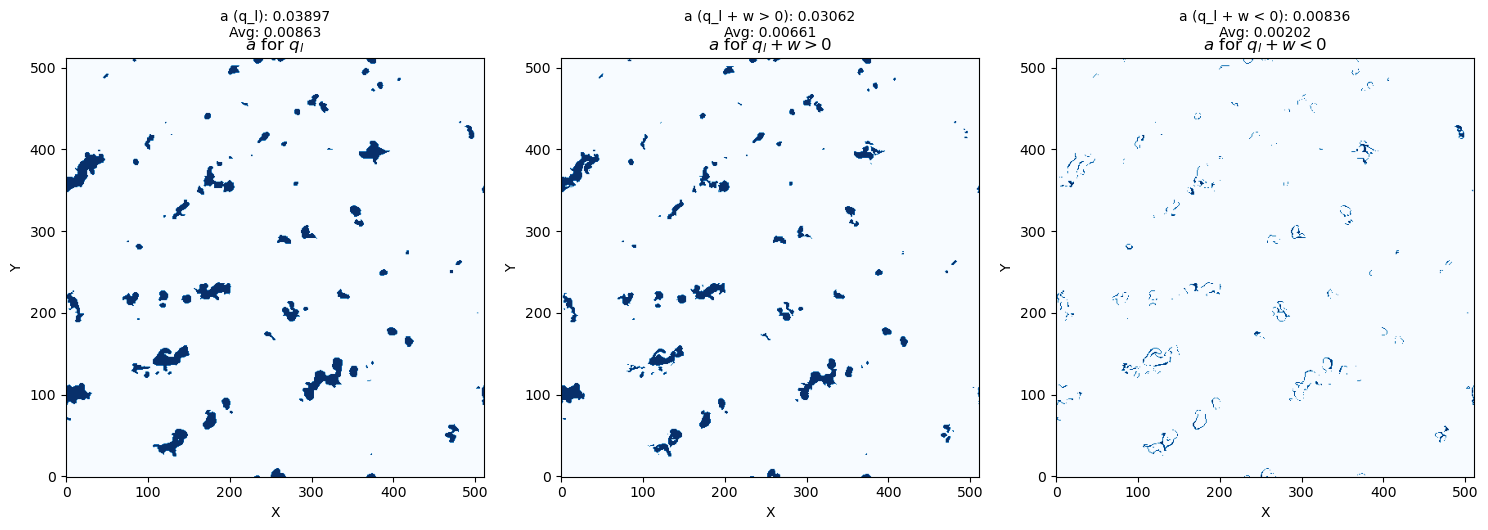

In [12]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Thresholds
liquid_water_threshold = 0.0000001

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def calculate_area_fractions(w_data, l_data, liquid_water_threshold):
    a_cloudy_total = []
    a_cloudy_w_pos_total = []
    a_cloudy_w_neg_total = []

    for z in range(w_data.shape[0]):
        # Cloudy masks
        cloudy_mask = l_data[z, :, :] > liquid_water_threshold
        cloudy_w_pos_mask = cloudy_mask & (w_data[z, :, :] > 0)
        cloudy_w_neg_mask = cloudy_mask & (w_data[z, :, :] < 0)

        a_cloudy_total.append(np.mean(cloudy_mask))
        a_cloudy_w_pos_total.append(np.mean(cloudy_w_pos_mask))
        a_cloudy_w_neg_total.append(np.mean(cloudy_w_neg_mask))

    # Calculate averages over all levels
    a_cloudy_avg = np.mean(a_cloudy_total)
    a_cloudy_w_pos_avg = np.mean(a_cloudy_w_pos_total)
    a_cloudy_w_neg_avg = np.mean(a_cloudy_w_neg_total)

    return a_cloudy_total, a_cloudy_w_pos_total, a_cloudy_w_neg_total, a_cloudy_avg, a_cloudy_w_pos_avg, a_cloudy_w_neg_avg

# Specify the timestep and height level to analyze
timestep = 15
height_level = 40  # Change this to your desired height level

# Load data for the specified timestep
w_data = load_data_all_levels(w_file, 'w', timestep)
l_data = load_data_all_levels(l_file, 'l', timestep)

# Extract data for the specified height level
w_data_height = w_data[height_level, :, :]
l_data_height = l_data[height_level, :, :]

# Calculate area fractions for the specified height level
cloudy_mask = l_data_height > liquid_water_threshold
cloudy_w_pos_mask = cloudy_mask & (w_data_height > 0)
cloudy_w_neg_mask = cloudy_mask & (w_data_height < 0)

a_cloudy = np.mean(cloudy_mask)
a_cloudy_w_pos = np.mean(cloudy_w_pos_mask)
a_cloudy_w_neg = np.mean(cloudy_w_neg_mask)

# Calculate area fractions averaged over all levels
a_cloudy_total, a_cloudy_w_pos_total, a_cloudy_w_neg_total, a_cloudy_avg, a_cloudy_w_pos_avg, a_cloudy_w_neg_avg = calculate_area_fractions(
    w_data, l_data, liquid_water_threshold
)

# Create plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot fraction for q_l
ax1.imshow(cloudy_mask, cmap='Blues', origin='lower')
ax1.set_title(r'$a$ for $q_l$')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.text(0.5, 1.05, f'a (q_l): {a_cloudy:.5f}\nAvg: {a_cloudy_avg:.5f}', transform=ax1.transAxes, ha='center')

# Plot fraction for q_l + w > 0
ax2.imshow(cloudy_w_pos_mask, cmap='Blues', origin='lower')
ax2.set_title(r'$a$ for $q_l + w > 0$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.text(0.5, 1.05, f'a (q_l + w > 0): {a_cloudy_w_pos:.5f}\nAvg: {a_cloudy_w_pos_avg:.5f}', transform=ax2.transAxes, ha='center')

# Plot fraction for q_l + w < 0
ax3.imshow(cloudy_w_neg_mask, cmap='Blues', origin='lower')
ax3.set_title(r'$a$ for $q_l + w < 0$')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.text(0.5, 1.05, f'a (q_l + w < 0): {a_cloudy_w_neg:.5f}\nAvg: {a_cloudy_w_neg_avg:.5f}', transform=ax3.transAxes, ha='center')

plt.tight_layout()
plt.show()


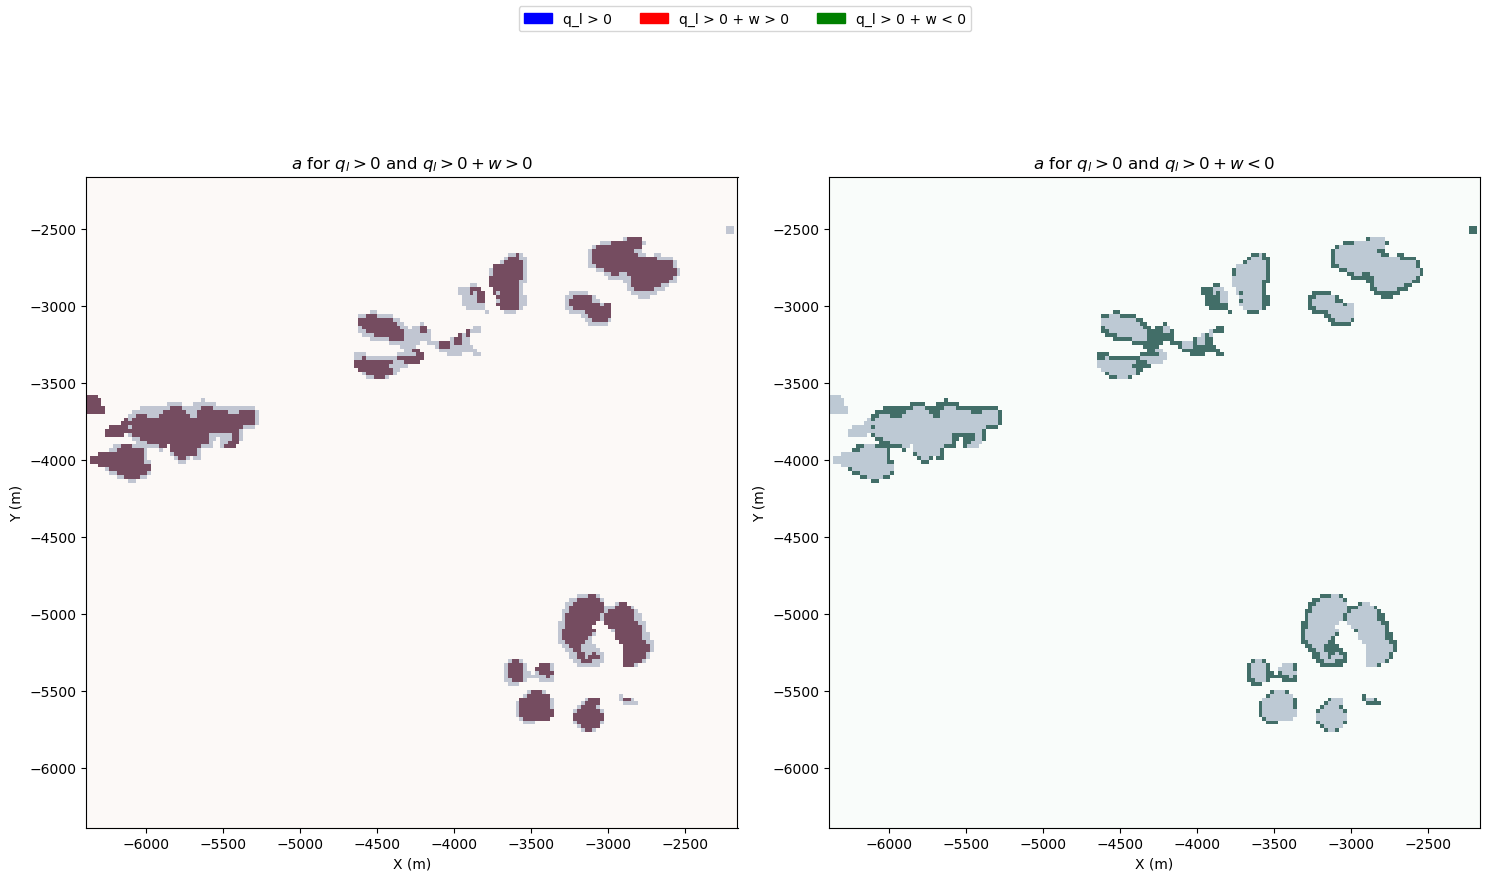

In [26]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Thresholds
liquid_water_threshold = 0.0000001

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
        x = ds.variables['xt'][:]
        y = ds.variables['yt'][:]
    return data, x, y

def calculate_area_fractions(w_data, l_data, liquid_water_threshold):
    a_cloudy_total = []
    a_cloudy_w_pos_total = []
    a_cloudy_w_neg_total = []

    for z in range(w_data.shape[0]):
        # Cloudy masks
        cloudy_mask = l_data[z, :, :] > liquid_water_threshold
        cloudy_w_pos_mask = cloudy_mask & (w_data[z, :, :] > 0)
        cloudy_w_neg_mask = cloudy_mask & (w_data[z, :, :] < 0)

        a_cloudy_total.append(np.mean(cloudy_mask))
        a_cloudy_w_pos_total.append(np.mean(cloudy_w_pos_mask))
        a_cloudy_w_neg_total.append(np.mean(cloudy_w_neg_mask))

    # Calculate averages over all levels
    a_cloudy_avg = np.mean(a_cloudy_total)
    a_cloudy_w_pos_avg = np.mean(a_cloudy_w_pos_total)
    a_cloudy_w_neg_avg = np.mean(a_cloudy_w_neg_total)

    return a_cloudy_total, a_cloudy_w_pos_total, a_cloudy_w_neg_total, a_cloudy_avg, a_cloudy_w_pos_avg, a_cloudy_w_neg_avg

# Specify the timestep and height level to analyze
timestep = 15
height_level = 50  # Change this to your desired height level

# Load data for the specified timestep
w_data, x, y = load_data_all_levels(w_file, 'w', timestep)
l_data, _, _ = load_data_all_levels(l_file, 'l', timestep)

# Extract data for the specified height level
w_data_height = w_data[height_level, :, :]
l_data_height = l_data[height_level, :, :]

# Calculate area fractions for the specified height level
cloudy_mask = l_data_height > liquid_water_threshold
cloudy_w_pos_mask = cloudy_mask & (w_data_height > 0)
cloudy_w_neg_mask = cloudy_mask & (w_data_height < 0)

# Get a quarter of the field
quarter_x = x[:x.shape[0]//3]
quarter_y = y[:y.shape[0]//3]
quarter_cloudy_mask = cloudy_mask[:cloudy_mask.shape[0]//3, :cloudy_mask.shape[1]//3]
quarter_cloudy_w_pos_mask = cloudy_w_pos_mask[:cloudy_w_pos_mask.shape[0]//3, :cloudy_w_pos_mask.shape[1]//3]
quarter_cloudy_w_neg_mask = cloudy_w_neg_mask[:cloudy_w_neg_mask.shape[0]//3, :cloudy_w_neg_mask.shape[1]//3]

# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), facecolor='white')

# Left plot: q_l > 0 and q_l > 0 + w > 0
ax1.imshow(quarter_cloudy_mask, cmap='Blues', origin='lower', alpha=0.5, extent=[quarter_x.min(), quarter_x.max(), quarter_y.min(), quarter_y.max()])
ax1.imshow(quarter_cloudy_w_pos_mask, cmap='Reds', origin='lower', alpha=0.5, extent=[quarter_x.min(), quarter_x.max(), quarter_y.min(), quarter_y.max()])
ax1.set_title(r'$a$ for $q_l > 0$ and $q_l > 0 + w > 0$')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')

# Right plot: q_l > 0 and q_l > 0 + w < 0
ax2.imshow(quarter_cloudy_mask, cmap='Blues', origin='lower', alpha=0.5, extent=[quarter_x.min(), quarter_x.max(), quarter_y.min(), quarter_y.max()])
ax2.imshow(quarter_cloudy_w_neg_mask, cmap='Greens', origin='lower', alpha=0.5, extent=[quarter_x.min(), quarter_x.max(), quarter_y.min(), quarter_y.max()])
ax2.set_title(r'$a$ for $q_l > 0$ and $q_l > 0 + w < 0$')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')

# Add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', edgecolor='blue', label='q_l > 0'),
    Patch(facecolor='red', edgecolor='red', label='q_l > 0 + w > 0'),
    Patch(facecolor='green', edgecolor='green', label='q_l > 0 + w < 0')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3)

plt.tight_layout()
plt.show()


## Adding total flux

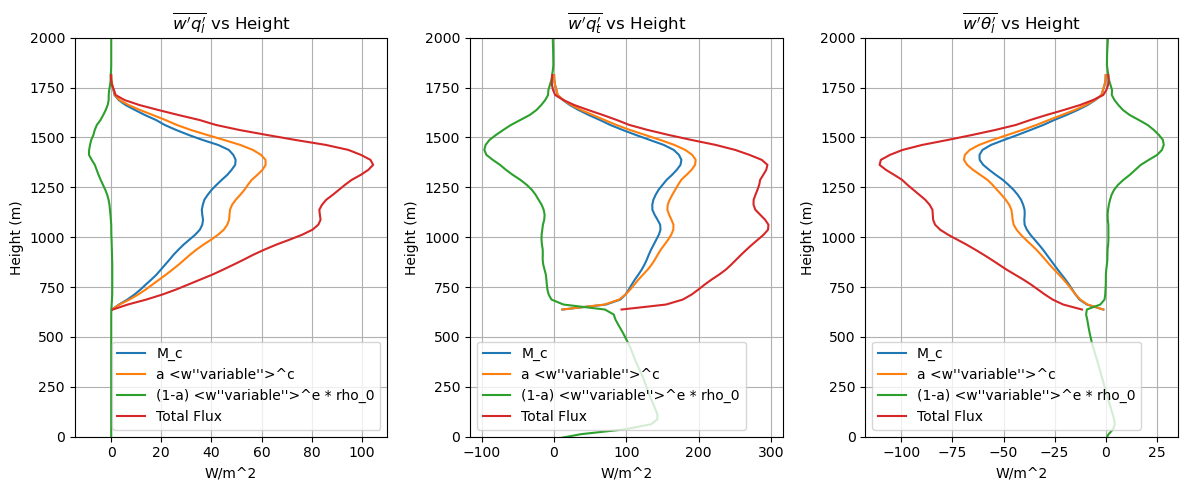

In [49]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Thresholds
liquid_water_threshold = 0.00001
vertical_velocity_threshold = 0.0

# Constants
rho_0 = 1.25  # kg/m^3
L_v = 2268000.0  # J/kg
c_p = 1004.0  # J/kg/K

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_M_c_values(w_data, l_data, variable_data, liquid_water_threshold, vertical_velocity_threshold, multiplier):
    M_c_values = []
    active_cloudy_values = []
    environment_values = []
    total_flux_values = []

    for z in range(w_data.shape[0]):
        # Cloudy and environment masks
        cloudy_mask = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] > vertical_velocity_threshold)
        environment_mask = ~cloudy_mask

        # Area fractions
        a = np.mean(cloudy_mask)

        # Mean vertical velocities and variable contents
        w_mean = np.mean(w_data[z, :, :])
        var_mean = np.mean(variable_data[z, :, :])
        
        w_c = np.mean(w_data[z, :, :][cloudy_mask])
        w_e = np.mean(w_data[z, :, :][environment_mask])

        var_c = np.mean(variable_data[z, :, :][cloudy_mask])
        var_e = np.mean(variable_data[z, :, :][environment_mask])

        # Perturbations (variable minus its mean)
        w_prime_c = w_data[z, :, :][cloudy_mask] - w_mean
        w_prime_e = w_data[z, :, :][environment_mask] - w_mean

        var_prime_c = variable_data[z, :, :][cloudy_mask] - var_mean
        var_prime_e = variable_data[z, :, :][environment_mask] - var_mean

        # Calculate a * <w''variable''>^c
        line1 = a * np.mean(w_prime_c * var_prime_c) * multiplier
        # Calculate (1 - a) * <w''variable''>^e * rho_0
        line2 = (1 - a) * np.mean(w_prime_e * var_prime_e) * multiplier

        # Calculate M_c
        M_c = a * (1 - a) * (w_c - w_e)
        # Multiply M_c with (var_c - var_e)
        result = M_c * (var_c - var_e) * multiplier

        # Append the result for the current vertical level
        M_c_values.append(result)
        active_cloudy_values.append(line1)
        environment_values.append(line2)
        total_flux_values.append(result + line1 + line2)

    # Convert the result lists to numpy arrays
    M_c_values = np.array(M_c_values)
    active_cloudy_values = np.array(active_cloudy_values)
    environment_values = np.array(environment_values)
    total_flux_values = np.array(total_flux_values)

    return M_c_values, active_cloudy_values, environment_values, total_flux_values

# Specify the timestep to analyze
specified_timestep = 30

# Load data for the specified timestep
w_data = load_data_all_levels(w_file, 'w', specified_timestep)
l_data = load_data_all_levels(l_file, 'l', specified_timestep)
q_l_data = load_data_all_levels(q_file, 'q', specified_timestep)
theta_l_data = load_data_all_levels(t_file, 't', specified_timestep)
zt_values = load_zt_values(l_file)

# Calculate M_c values for liquid water content
M_c_l_values, active_cloudy_l_values, environment_l_values, total_flux_l_values = calculate_M_c_values(
    w_data, l_data, l_data, liquid_water_threshold, vertical_velocity_threshold, rho_0 * L_v)

# Calculate M_c values for total water content
M_c_qt_values, active_cloudy_qt_values, environment_qt_values, total_flux_qt_values = calculate_M_c_values(
    w_data, l_data, q_l_data, liquid_water_threshold, vertical_velocity_threshold, rho_0 * L_v)

# Calculate M_c values for liquid water potential temperature
M_c_theta_l_values, active_cloudy_theta_l_values, environment_theta_l_values, total_flux_theta_l_values = calculate_M_c_values(
    w_data, l_data, theta_l_data, liquid_water_threshold, vertical_velocity_threshold, rho_0 * c_p)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

def plot_with_additional_lines(ax, M_c_values, active_cloudy_values, environment_values, total_flux_values, title):
    ax.plot(M_c_values, zt_values, label='M_c')
    ax.plot(active_cloudy_values, zt_values, label='a <w\'\'variable\'\'>^c')
    ax.plot(environment_values, zt_values, label='(1-a) <w\'\'variable\'\'>^e * rho_0')
    ax.plot(total_flux_values, zt_values, label='Total Flux')

    ax.set_xlabel('W/m^2')
    ax.set_ylabel('Height (m)')
    ax.set_title(title)
    ax.grid(True)
    ax.set_ylim([0, 2000])
    ax.legend()

plot_with_additional_lines(ax1, M_c_l_values, active_cloudy_l_values, environment_l_values, total_flux_l_values, r'$\overline{w^{\prime}q_l^{\prime}}$ vs Height')
plot_with_additional_lines(ax2, M_c_qt_values, active_cloudy_qt_values, environment_qt_values, total_flux_qt_values, r'$\overline{w^{\prime}q_t^{\prime}}$ vs Height')
plot_with_additional_lines(ax3, M_c_theta_l_values, active_cloudy_theta_l_values, environment_theta_l_values, total_flux_theta_l_values, r'$\overline{w^{\prime}\theta_l^{\prime}}$ vs Height')

plt.tight_layout()
plt.show()


## Average over time

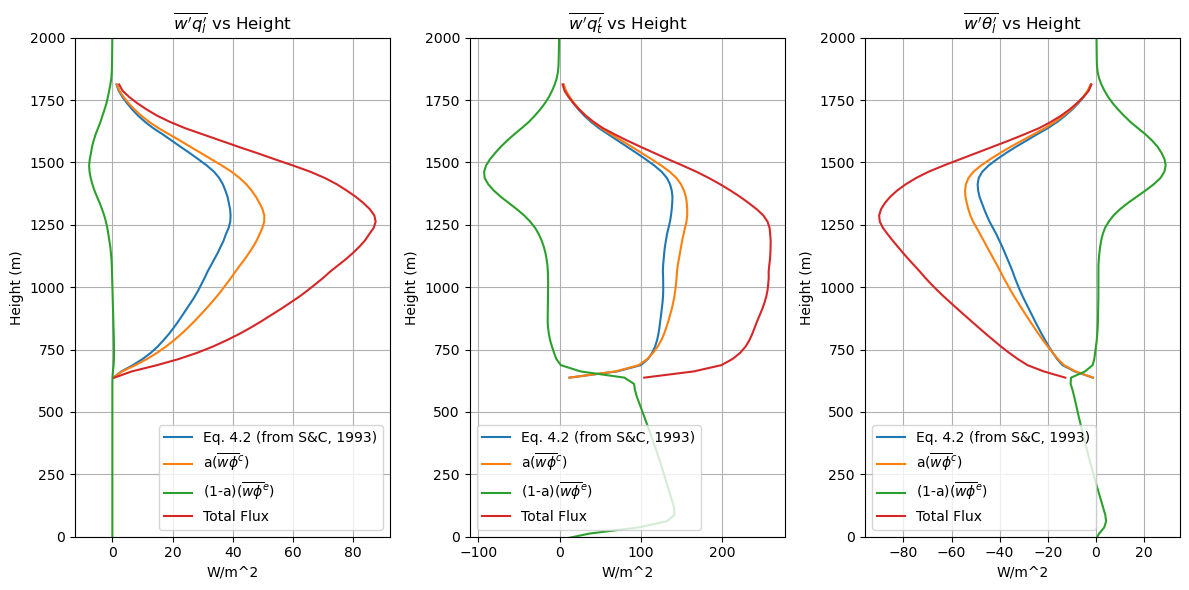

In [56]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Thresholds
liquid_water_threshold = 0.00001
vertical_velocity_threshold = 0.0

# Constants
rho_0 = 1.25  # kg/m^3
L_v = 2268000.0  # J/kg
c_p = 1004.0  # J/kg/K

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_M_c_values(w_data, l_data, variable_data, liquid_water_threshold, vertical_velocity_threshold, multiplier):
    M_c_values = []
    active_cloudy_values = []
    environment_values = []
    total_flux_values = []

    for z in range(w_data.shape[0]):
        # Cloudy and environment masks
        cloudy_mask = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] > vertical_velocity_threshold)
        environment_mask = ~cloudy_mask

        # Area fractions
        a = np.mean(cloudy_mask)

        # Mean vertical velocities and variable contents
        w_mean = np.mean(w_data[z, :, :])
        var_mean = np.mean(variable_data[z, :, :])
        
        w_c = np.mean(w_data[z, :, :][cloudy_mask])
        w_e = np.mean(w_data[z, :, :][environment_mask])

        var_c = np.mean(variable_data[z, :, :][cloudy_mask])
        var_e = np.mean(variable_data[z, :, :][environment_mask])

        # Perturbations (variable minus its mean)
        w_prime_c = np.nan_to_num(w_data[z, :, :][cloudy_mask] - w_mean)
        w_prime_e = np.nan_to_num(w_data[z, :, :][environment_mask] - w_mean)

        var_prime_c = np.nan_to_num(variable_data[z, :, :][cloudy_mask] - var_mean)
        var_prime_e = np.nan_to_num(variable_data[z, :, :][environment_mask] - var_mean)

        # Calculate a * <w''variable''>^c
        line1 = a * np.mean(w_prime_c * var_prime_c) * multiplier
        # Calculate (1 - a) * <w''variable''>^e * rho_0
        line2 = (1 - a) * np.mean(w_prime_e * var_prime_e) * multiplier

        # Calculate M_c
        M_c = a * (1 - a) * (w_c - w_e)
        # Multiply M_c with (var_c - var_e)
        result = M_c * (var_c - var_e) * multiplier

        # Append the result for the current vertical level
        M_c_values.append(result)
        active_cloudy_values.append(line1)
        environment_values.append(line2)
        total_flux_values.append(result + line1 + line2)

    # Convert the result lists to numpy arrays
    M_c_values = np.array(M_c_values)
    active_cloudy_values = np.array(active_cloudy_values)
    environment_values = np.array(environment_values)
    total_flux_values = np.array(total_flux_values)

    return M_c_values, active_cloudy_values, environment_values, total_flux_values

def average_M_c_values_over_time(start_timestep, end_timestep, variable_data_loader, multiplier):
    M_c_values_total = None
    active_cloudy_values_total = None
    environment_values_total = None
    total_flux_values_total = None

    num_timesteps = end_timestep - start_timestep

    for timestep in range(start_timestep, end_timestep):
        w_data = load_data_all_levels(w_file, 'w', timestep)
        l_data = load_data_all_levels(l_file, 'l', timestep)
        variable_data = variable_data_loader(timestep)

        M_c_values, active_cloudy_values, environment_values, total_flux_values = calculate_M_c_values(
            w_data, l_data, variable_data, liquid_water_threshold, vertical_velocity_threshold, multiplier
        )

        if M_c_values_total is None:
            M_c_values_total = M_c_values
            active_cloudy_values_total = active_cloudy_values
            environment_values_total = environment_values
            total_flux_values_total = total_flux_values
        else:
            M_c_values_total += M_c_values
            active_cloudy_values_total += active_cloudy_values
            environment_values_total += environment_values
            total_flux_values_total += total_flux_values

    M_c_values_total /= num_timesteps
    active_cloudy_values_total /= num_timesteps
    environment_values_total /= num_timesteps
    total_flux_values_total /= num_timesteps

    return M_c_values_total, active_cloudy_values_total, environment_values_total, total_flux_values_total

# Specify the time range to analyze (e.g., timesteps 15 to 25)
start_timestep = 15
end_timestep = 25

# Load height values
zt_values = load_zt_values(l_file)

# Calculate and average M_c values for liquid water content
M_c_l_values, active_cloudy_l_values, environment_l_values, total_flux_l_values = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(l_file, 'l', timestep), rho_0 * L_v)

# Calculate and average M_c values for total water content
M_c_qt_values, active_cloudy_qt_values, environment_qt_values, total_flux_qt_values = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(q_file, 'q', timestep), rho_0 * L_v)

# Calculate and average M_c values for liquid water potential temperature
M_c_theta_l_values, active_cloudy_theta_l_values, environment_theta_l_values, total_flux_theta_l_values = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(t_file, 't', timestep), rho_0 * c_p)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

def plot_with_additional_lines(ax, M_c_values, active_cloudy_values, environment_values, total_flux_values, title):
    ax.plot(M_c_values, zt_values, label='Eq 4.2 (S&C, 1993)')
    ax.plot(active_cloudy_values, zt_values, label='a($\overline{w''\phi''}^c$)')
    ax.plot(environment_values, zt_values, label='(1-a)($\overline{w''\phi''}^e$)')
    ax.plot(total_flux_values, zt_values, label='Total Flux')

    ax.set_xlabel('W/m^2')
    ax.set_ylabel('Height (m)')
    ax.set_title(title)
    ax.grid(True)
    ax.set_ylim([0, 2000])
    ax.legend()

plot_with_additional_lines(ax1, M_c_l_values, active_cloudy_l_values, environment_l_values, total_flux_l_values, r'$\overline{w^{\prime}q_l^{\prime}}$')
plot_with_additional_lines(ax2, M_c_qt_values, active_cloudy_qt_values, environment_qt_values, total_flux_qt_values, r'$\overline{w^{\prime}q_t^{\prime}}$')
plot_with_additional_lines(ax3, M_c_theta_l_values, active_cloudy_theta_l_values, environment_theta_l_values, total_flux_theta_l_values, r'$\overline{w^{\prime}\theta_l^{\prime}}$')

plt.tight_layout()
plt.show()


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_11906/2803667159.py:102: UserWarning: Warning: converting a masked element to nan.
  M_c_values = np.array(M_c_values)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_11906/2803667159.py:103: UserWarning: Warning: converting a masked element to nan.
  active_cloudy_values = np.array(active_cloudy_values)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_11906/2803667159.py:105: UserWarning: Warning: converting a masked element to nan.
  total_flux_values = np.array(total_flux_values)


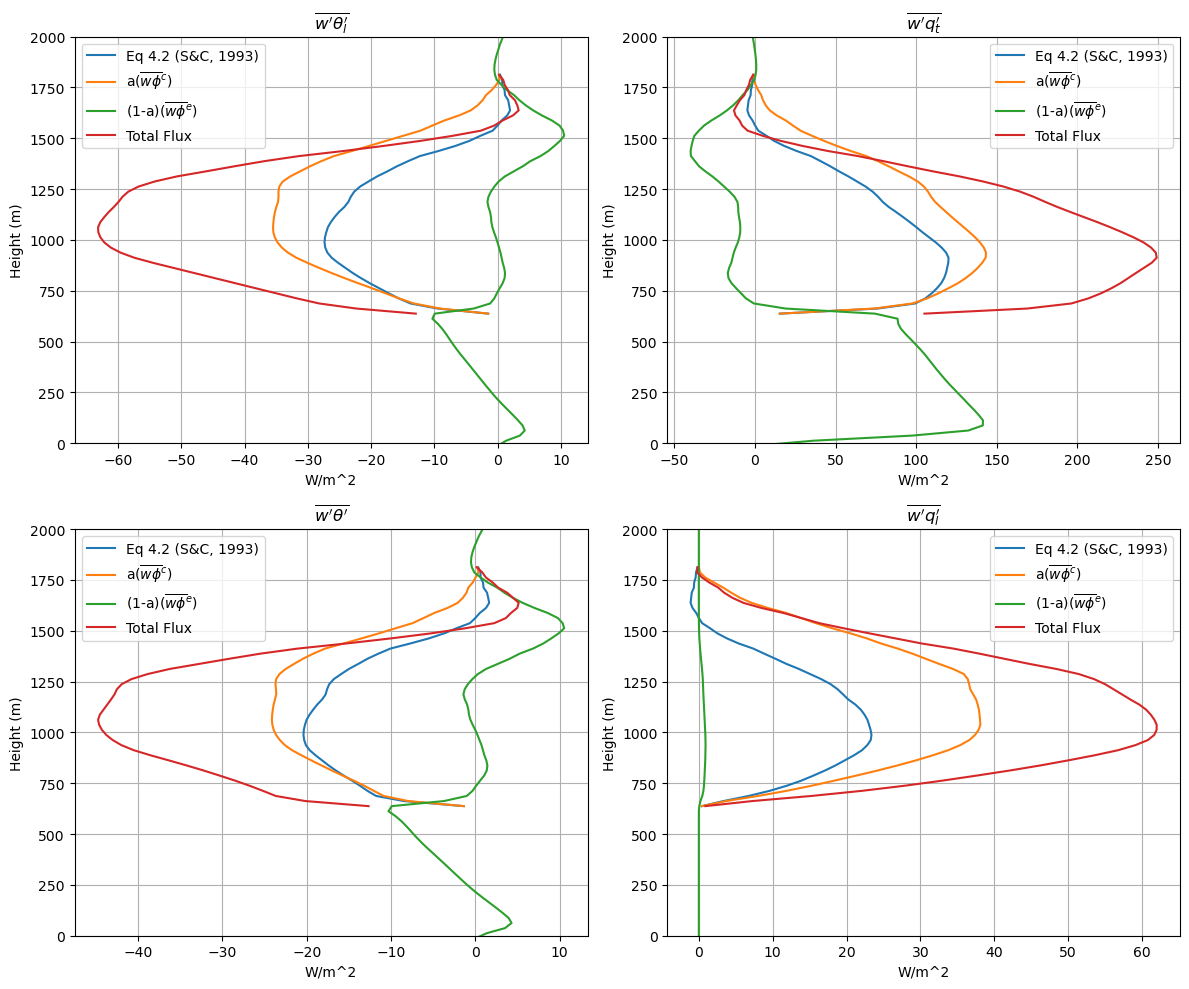

In [50]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Thresholds
liquid_water_threshold = 0.00001

# Constants
rho_0 = 1.25  # kg/m^3
L_v = 2268000.0  # J/kg
c_p = 1004.0  # J/kg/K
R_d = 287.05  # J/kg/K gas constant for dry air
R_v = 461.51  # J/kg/K gas constant for water vapor
p_0 = 100000.0  # Pa standard pressure at sea level
c_pd = 1004.0  # J/kg/K specific heat capacity of dry air
c_pv = 1996.0  # J/kg/K specific heat capacity of water vapor
rho_l = 1000.0  # kg/m^3 density of water
epsilon = R_d / R_v
horizontal_resolution = 25.0  # in meters

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_temperature(theta_l, p, q_t, q_l, q_v):
    """Calculate temperature from theta_l, pressure, total water, and water vapor mixing ratios."""
    kappa = (R_d / c_pd) * ((1 + q_v / epsilon) / (1 + q_v * (c_pv / c_pd)))
    T = theta_l * (c_pd / (c_pd - L_v * q_l)) * (p_0 / p) ** (-kappa)
    return T

def calculate_theta(T, p):
    """Calculate potential temperature theta from temperature and pressure."""
    return T * (p_0 / p) ** kappa

def calculate_density(T, p, q_l, q_v):
    """Calculate air density from temperature, pressure, and liquid water mixing ratio."""
    p_v = (q_v / (q_v + epsilon)) * p
    rho = (p - p_v) / (R_d * T) + (p_v / (R_v * T)) + (q_l * rho_l)
    return rho

def calculate_M_c_values(w_data, l_data, variable_data, liquid_water_threshold, multiplier):
    M_c_values = []
    active_cloudy_values = []
    environment_values = []
    total_flux_values = []

    for z in range(w_data.shape[0]):
        # Cloudy and environment masks
        cloudy_mask = l_data[z, :, :] > liquid_water_threshold
        environment_mask = ~cloudy_mask

        # Area fractions
        a = np.mean(cloudy_mask)

        # Mean vertical velocities and variable contents
        w_mean = np.mean(w_data[z, :, :])
        var_mean = np.mean(variable_data[z, :, :])
        
        w_c = np.mean(w_data[z, :, :][cloudy_mask])
        w_e = np.mean(w_data[z, :, :][environment_mask])

        var_c = np.mean(variable_data[z, :, :][cloudy_mask])
        var_e = np.mean(variable_data[z, :, :][environment_mask])

        # Perturbations (variable minus its mean)
        w_prime_c = np.nan_to_num(w_data[z, :, :][cloudy_mask] - w_mean)
        w_prime_e = np.nan_to_num(w_data[z, :, :][environment_mask] - w_mean)

        var_prime_c = np.nan_to_num(variable_data[z, :, :][cloudy_mask] - var_mean)
        var_prime_e = np.nan_to_num(variable_data[z, :, :][environment_mask] - var_mean)

        # Calculate a * <w''variable''>^c
        line1 = a * np.mean(w_prime_c * var_prime_c) * multiplier
        # Calculate (1 - a) * <w''variable''>^e * rho_0
        line2 = (1 - a) * np.mean(w_prime_e * var_prime_e) * multiplier

        # Calculate M_c
        M_c = a * (1 - a) * (w_c - w_e)
        # Multiply M_c with (var_c - var_e)
        result = M_c * (var_c - var_e) * multiplier

        # Append the result for the current vertical level
        M_c_values.append(result)
        active_cloudy_values.append(line1)
        environment_values.append(line2)
        total_flux_values.append(result + line1 + line2)

    # Convert the result lists to numpy arrays
    M_c_values = np.array(M_c_values)
    active_cloudy_values = np.array(active_cloudy_values)
    environment_values = np.array(environment_values)
    total_flux_values = np.array(total_flux_values)

    return M_c_values, active_cloudy_values, environment_values, total_flux_values

def average_M_c_values_over_time(start_timestep, end_timestep, variable_data_loader, multiplier):
    M_c_values_total = None
    active_cloudy_values_total = None
    environment_values_total = None
    total_flux_values_total = None

    num_timesteps = end_timestep - start_timestep

    for timestep in range(start_timestep, end_timestep):
        w_data = load_data_all_levels(w_file, 'w', timestep)
        l_data = load_data_all_levels(l_file, 'l', timestep)
        variable_data = variable_data_loader(timestep)

        M_c_values, active_cloudy_values, environment_values, total_flux_values = calculate_M_c_values(
            w_data, l_data, variable_data, liquid_water_threshold, multiplier
        )

        if M_c_values_total is None:
            M_c_values_total = M_c_values
            active_cloudy_values_total = active_cloudy_values
            environment_values_total = environment_values
            total_flux_values_total = total_flux_values
        else:
            M_c_values_total += M_c_values
            active_cloudy_values_total += active_cloudy_values
            environment_values_total += environment_values
            total_flux_values_total += total_flux_values

    M_c_values_total /= num_timesteps
    active_cloudy_values_total /= num_timesteps
    environment_values_total /= num_timesteps
    total_flux_values_total /= num_timesteps

    return M_c_values_total, active_cloudy_values_total, environment_values_total, total_flux_values_total

# Specify the time range to analyze (e.g., timesteps 15 to 25)
start_timestep = 22
end_timestep = 25

# Load height values
zt_values = load_zt_values(l_file)

# Calculate and average M_c values for liquid water content
M_c_l_values, active_cloudy_l_values, environment_l_values, total_flux_l_values = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(l_file, 'l', timestep), rho_0 * L_v)

# Calculate and average M_c values for total water content
M_c_qt_values, active_cloudy_qt_values, environment_qt_values, total_flux_qt_values = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(q_file, 'q', timestep), rho_0 * L_v)

# Calculate and average M_c values for liquid water potential temperature
M_c_theta_l_values, active_cloudy_theta_l_values, environment_theta_l_values, total_flux_theta_l_values = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(t_file, 't', timestep), rho_0 * c_p)

# Calculate and average M_c values for theta
def variable_data_loader_theta(timestep):
    t_data = load_data_all_levels(t_file, 't', timestep)
    p_data = load_data_all_levels(p_file, 'p', timestep)
    q_data = load_data_all_levels(q_file, 'q', timestep) / 1000
    l_data = load_data_all_levels(l_file, 'l', timestep) / 1000
    q_v_data = (q_data - l_data)
    
    # Calculate temperature
    T = calculate_temperature(t_data, p_data, q_data, l_data, q_v_data)
    
    # Calculate theta
    theta = calculate_theta(T, p_data)
    return theta

M_c_theta_values, active_cloudy_theta_values, environment_theta_values, total_flux_theta_values = average_M_c_values_over_time(
    start_timestep, end_timestep, variable_data_loader_theta, rho_0 * c_p)

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

def plot_with_additional_lines(ax, M_c_values, active_cloudy_values, environment_values, total_flux_values, title):
    ax.plot(M_c_values, zt_values, label='Eq 4.2 (S&C, 1993)')
    ax.plot(active_cloudy_values, zt_values, label='a($\overline{w''\phi''}^c$)')
    ax.plot(environment_values, zt_values, label='(1-a)($\overline{w''\phi''}^e$)')
    ax.plot(total_flux_values, zt_values, label='Total Flux')

    ax.set_xlabel('W/m^2')
    ax.set_ylabel('Height (m)')
    ax.set_title(title)
    ax.grid(True)
    ax.set_ylim([0, 2000])
    ax.legend()

plot_with_additional_lines(ax1, M_c_theta_l_values, active_cloudy_theta_l_values, environment_theta_l_values, total_flux_theta_l_values, r'$\overline{w^{\prime}\theta_l^{\prime}}$')
plot_with_additional_lines(ax2, M_c_qt_values, active_cloudy_qt_values, environment_qt_values, total_flux_qt_values, r'$\overline{w^{\prime}q_t^{\prime}}$')
plot_with_additional_lines(ax3, M_c_theta_values, active_cloudy_theta_values, environment_theta_values, total_flux_theta_values, r'$\overline{w^{\prime}\theta^{\prime}}$')
plot_with_additional_lines(ax4, M_c_l_values, active_cloudy_l_values, environment_l_values, total_flux_l_values, r'$\overline{w^{\prime}q_l^{\prime}}$')

plt.tight_layout()
plt.show()


Two crucial plots: 
- additional variables and their fluxes
- Adding other two terms which add together to total flux


From the Siebesma & Cuijpers paper: how is the heat flux of liquid water **outside core** positve?!

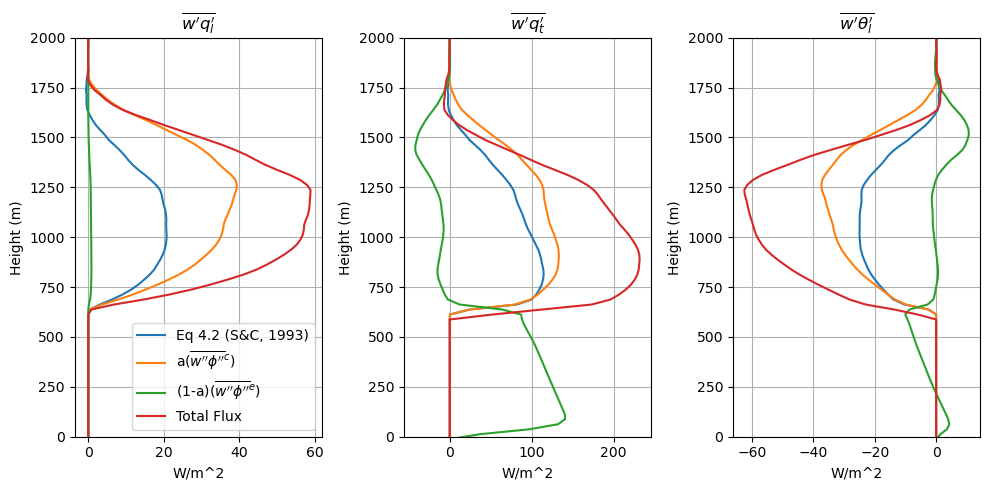

In [66]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Thresholds
liquid_water_threshold = 0.0000001
vertical_velocity_threshold = 0.0

# Constants
rho_0 = 1.25  # kg/m^3
L_v = 2268000.0  # J/kg
c_p = 1004.0  # J/kg/K

# File paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_M_c_values(w_data, l_data, variable_data, liquid_water_threshold, vertical_velocity_threshold, multiplier):
    M_c_values = []
    active_cloudy_values = []
    environment_values = []
    total_flux_values = []

    for z in range(w_data.shape[0]):
        # Cloudy and environment masks
        #cloudy_mask = (l_data[z, :, :] > liquid_water_threshold) & (w_data[z, :, :] > vertical_velocity_threshold)
        cloudy_mask = (l_data[z, :, :] > liquid_water_threshold)
        environment_mask = ~cloudy_mask

        # Area fractions
        a = np.mean(cloudy_mask)

        # Mean vertical velocities and variable contents
        w_mean = np.mean(w_data[z, :, :])
        var_mean = np.mean(variable_data[z, :, :])
        
        w_c = np.mean(w_data[z, :, :][cloudy_mask])
        w_e = np.mean(w_data[z, :, :][environment_mask])

        var_c = np.mean(variable_data[z, :, :][cloudy_mask])
        var_e = np.mean(variable_data[z, :, :][environment_mask])

        # Perturbations (variable minus its mean)
        w_prime_c = np.nan_to_num(w_data[z, :, :][cloudy_mask] - w_mean, nan=0.0)
        w_prime_e = np.nan_to_num(w_data[z, :, :][environment_mask] - w_mean, nan=0.0)

        var_prime_c = np.nan_to_num(variable_data[z, :, :][cloudy_mask] - var_mean, nan=0.0)
        var_prime_e = np.nan_to_num(variable_data[z, :, :][environment_mask] - var_mean, nan=0.0)

        # Calculate a * <w''variable''>^c
        line1 = a * np.mean(w_prime_c * var_prime_c) * multiplier
        # Calculate (1 - a) * <w''variable''>^e * rho_0
        line2 = (1 - a) * np.mean(w_prime_e * var_prime_e) * multiplier

        # Calculate M_c
        M_c = a * (1 - a) * (w_c - w_e)
        # Multiply M_c with (var_c - var_e)
        result = M_c * (var_c - var_e) * multiplier

        # Append the result for the current vertical level
        M_c_values.append(np.nan_to_num(result, nan=0.0))
        active_cloudy_values.append(np.nan_to_num(line1, nan=0.0))
        environment_values.append(np.nan_to_num(line2, nan=0.0))
        total_flux_values.append(np.nan_to_num(result + line1 + line2, nan=0.0))

    # Convert the result lists to numpy arrays
    M_c_values = np.array(M_c_values)
    active_cloudy_values = np.array(active_cloudy_values)
    environment_values = np.array(environment_values)
    total_flux_values = np.array(total_flux_values)

    return M_c_values, active_cloudy_values, environment_values, total_flux_values

def average_M_c_values_over_time(start_timestep, end_timestep, variable_data_loader, multiplier):
    M_c_values_total = None
    active_cloudy_values_total = None
    environment_values_total = None
    total_flux_values_total = None

    num_timesteps = end_timestep - start_timestep

    for timestep in range(start_timestep, end_timestep):
        w_data = load_data_all_levels(w_file, 'w', timestep)
        l_data = load_data_all_levels(l_file, 'l', timestep)
        variable_data = variable_data_loader(timestep)

        M_c_values, active_cloudy_values, environment_values, total_flux_values = calculate_M_c_values(
            w_data, l_data, variable_data, liquid_water_threshold, vertical_velocity_threshold, multiplier
        )

        if M_c_values_total is None:
            M_c_values_total = M_c_values
            active_cloudy_values_total = active_cloudy_values
            environment_values_total = environment_values
            total_flux_values_total = total_flux_values
        else:
            M_c_values_total += M_c_values
            active_cloudy_values_total += active_cloudy_values
            environment_values_total += environment_values
            total_flux_values_total += total_flux_values

    M_c_values_total /= num_timesteps
    active_cloudy_values_total /= num_timesteps
    environment_values_total /= num_timesteps
    total_flux_values_total /= num_timesteps

    return M_c_values_total, active_cloudy_values_total, environment_values_total, total_flux_values_total

# Specify the time range to analyze (e.g., timesteps 15 to 25)
start_timestep = 20
end_timestep = 25

# Load height values
zt_values = load_zt_values(l_file)

# Calculate and average M_c values for liquid water content
M_c_l_values, active_cloudy_l_values, environment_l_values, total_flux_l_values = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(l_file, 'l', timestep), rho_0 * L_v)

# Calculate and average M_c values for total water content
M_c_qt_values, active_cloudy_qt_values, environment_qt_values, total_flux_qt_values = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(q_file, 'q', timestep), rho_0 * L_v)

# Calculate and average M_c values for liquid water potential temperature
M_c_theta_l_values, active_cloudy_theta_l_values, environment_theta_l_values, total_flux_theta_l_values = average_M_c_values_over_time(
    start_timestep, end_timestep, lambda timestep: load_data_all_levels(t_file, 't', timestep), rho_0 * c_p)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

def plot_with_additional_lines(ax, M_c_values, active_cloudy_values, environment_values, total_flux_values, title, show_legend=False):
    ax.plot(M_c_values, zt_values, label='Eq 4.2 (S&C, 1993)')
    ax.plot(active_cloudy_values, zt_values, label='a($\overline{w\'\'\phi\'\'}^c$)')
    ax.plot(environment_values, zt_values, label='(1-a)($\overline{w\'\'\phi\'\'}^e$)')
    ax.plot(total_flux_values, zt_values, label='Total Flux')

    ax.set_xlabel('W/m^2')
    ax.set_ylabel('Height (m)')
    ax.set_title(title)
    ax.grid(True)
    ax.set_ylim([0, 2000])
    if show_legend:
        ax.legend()

plot_with_additional_lines(ax1, M_c_l_values, active_cloudy_l_values, environment_l_values, total_flux_l_values, r'$\overline{w^{\prime}q_l^{\prime}}$', show_legend=True)
plot_with_additional_lines(ax2, M_c_qt_values, active_cloudy_qt_values, environment_qt_values, total_flux_qt_values, r'$\overline{w^{\prime}q_t^{\prime}}$')
plot_with_additional_lines(ax3, M_c_theta_l_values, active_cloudy_theta_l_values, environment_theta_l_values, total_flux_theta_l_values, r'$\overline{w^{\prime}\theta_l^{\prime}}$')

plt.tight_layout()
plt.show()

